# AB-тестирование
## Задание AB.5


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

---

**Баллы за задание:**

* Задача 1 — 50 баллов
* Задача 2 — 30 баллов
* Задача 3 — 120 баллов


In [1]:
# Bot check

# HW_ID: ds_ab5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

Приветик! Перед тобой очередное захватывающее домашнее задание по АБ-тестированию. Возьми чай или кофе, усаживайся поудобнее, настрой музыку в свой ритм, и поехали!

In [230]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from statsmodels.formula.api import ols

from statsmodels.stats.proportion import proportion_confint

from joblib import Parallel, delayed

sns.set(palette='Set2', style='whitegrid', font_scale=1.3)

---

### Задача 1.

Начнем с очень простой задачки для разогрева. Напомним, для ratio-метрик мы хотим подобрать критерий, удовлетворяющий следующим свойствам:
1. Корректность &mdash; контролирование вероятности ошибки 1 рода;
2. Сонаправленность метрики критерия с исходной ratio-метрикой;
3. Возможность применения CUPED для повышения чувствительности.

Возьмем функцию генерации искусственных данных с занятия, в которой также генерируются предэкспериментальные данные. Будем рассматривать 1000 пользователей.

**1.** Проверь визуально, насколько выполняется сонаправленность для метода бакетов в зависимости от количества бакетов. Рассмотри случаи 10, 20, 30, 50 бакетов, и, может быть, несколько других.

*Ты же понимаешь, что надо позапускать код с занятия для разных параметров? :)*

Код с занятия

In [23]:
def test_simulation(test, generate_sample_x, generate_sample_y):
    """
    Проведение одного теста на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_x, generate_sample_y -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости

    Возвращает: pvalue
    """

    # Генерируем выборки
    x = generate_sample_x(size=sample_size)
    y = generate_sample_y(size=sample_size)

    # Применяем критерий
    return test(x, y)[1]


def run_experiments(
    test,
    generate_sample_x,
    generate_sample_y=None,
    n_iter=10000,
    sample_size=1000,
    alpha=0.05,
    draw=True,
    show_pvals=True,
    n_jobs=4,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_x, generate_sample_y -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    draw -- рисовать ли график
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    """

    if generate_sample_y is None:
        generate_sample_y = generate_sample_x

    # Производим итерации
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(test_simulation)(test, generate_sample_x, generate_sample_y)
        for _ in tqdm(range(n_iter), leave=False)
    )
    n_rejects = (np.array(pvals) < alpha).sum()

    # Оценка вероятности ошибки первого рода
    type_1_prob_est, left_bound, right_bound = estimate_reject_prob(
        n_rejects, n_iter
    )

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            type_1_prob_est,
            left_bound,
            right_bound,
            show_pvals,
            pvals,
            alpha,
            figsize,
        )

    return type_1_prob_est, (left_bound, right_bound)


def visualization(
    prob_reject,
    left_bound,
    right_bound,
    show_pvals=False,
    pvals=None,
    alpha=0.05,
    figsize=(7, 2),
):
    """
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)
    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    """

    # построение гистограммы p-value (опционально)
    if show_pvals:
        with sns.axes_style("whitegrid"):
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            plt.hist(
                pvals,
                bins=np.linspace(0, 1, 21),
                alpha=0.7,
                weights=np.ones(len(pvals)) / len(pvals),
            )
            plt.title("Распределение p-value")

    # отрисовка интервала для вероятности отвержения критерия
    with sns.axes_style("whitegrid"):
        if show_pvals:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=figsize)
        plt.hlines(0, 0, 1, color="black", lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color="red", lw=5, linestyle="--", alpha=0.6)
        plt.fill_between(
            [left_bound, right_bound],
            [0.15] * 2,
            [-0.15] * 2,
            color="green",
            alpha=0.6,
        )
        plt.scatter(prob_reject, 0, s=300, marker="*", color="red")
        plt.xlim(
            (min(alpha, left_bound) - 1e-3, max(alpha, right_bound) + 1e-3)
        )
        plt.title(
            f"Доля отвержений = {100*prob_reject:.2f}%, "
            f"интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)"
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()


def estimate_reject_prob(n_rejects, n_iter):
    """
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    """

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(
        n_rejects, n_iter, method="wilson"
    )

    return prob_reject, left_bound, right_bound


def draw_power(
    powers,
    left_powers,
    right_powers,
    effects_list=np.linspace(0, 0.1, 11),
    label=None,
    title="Графики мощности",
    new_figure=False,
):
    """
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    powers -- оценка мощности
    left_powers, right_powers -- границы соотв. дов. интервала
    effects -- сетка эффектов
    real_alpha -- оценка реальной мощности
    left_alpha, right_alpha -- границы соотв. дов. интервала
    title -- заголовок графика
    """

    if new_figure:
        plt.figure(figsize=(10, 4))

    plt.plot(effects_list, powers, label=label, lw=3)
    plt.fill_between(effects_list, left_powers, right_powers, alpha=0.3)

    if new_figure:
        plt.hlines(
            0.8,
            effects_list[0],
            effects_list[-1],
            color="black",
            alpha=0.5,
            label="Мощность 0.8 (пересечение — MDE)",
        )
    plt.legend()
    plt.xlabel("Размер относительного эффекта")
    plt.ylabel("Мощность")
    plt.title(title)

def generate_session_sample(
    n_users=100, min_session_count=0, max_session_count=30, effect=0
):
    """
    Генерация данных пользовательских сессий

    n_users -- количество пользователей
    min_session_count -- минимальное количество сессий на пользователя
    max_session_count -- максимальное количество сессий на пользователя
    effect -- добавляемый эффект
    """

    # Параметр формы гамма-распределения для каждого пользователя
    user_parameters = np.random.uniform(size=n_users, low=1, high=20)
    # Количество сессий каждого пользователя
    user_session_counts = np.random.randint(
        size=n_users, low=min_session_count, high=max_session_count + 1
    )

    users = []
    session_lengths = []
    # Для каждого пользователя генерируем все его сессии
    for user_id in range(n_users):
        users += [f"id_{user_id}"] * user_session_counts[user_id]
        session_lengths += list(
            np.random.gamma(
                shape=user_parameters[user_id],
                size=user_session_counts[user_id],
            )
            * (1 + effect)
        )

    # Заносим в табличку
    data = pd.DataFrame(
        {
            "user_id": users,
            "session_lengths": np.array(session_lengths, dtype=float),
        }
    )

    return data

def bucket_transform(
    data,
    numerator_name="session_lengths",
    user_name="user_id",
    denominator_name=None,
    num_buckets=10,
):
    """
    Создает бакеты из данных.

    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    num_buckets -- число бакетов

    Возвращает сгруппированные данные
    """

    if denominator_name is None:
        denominator_name = "ratio_denominator"
        data[denominator_name] = 1

    data["bucket"] = data[user_name].apply(lambda x: np.abs(hash(x)) % num_buckets)
    groupped_data = data.groupby(by="bucket")[[numerator_name, denominator_name]].sum()
    groupped_data["values"] = (
        groupped_data[numerator_name] / groupped_data[denominator_name]
    )
    return groupped_data


def generate_transform(
    n_users=100,
    min_session_count=0,
    max_session_count=30,
    num_buckets=10,
    effect=0,
):
    """
    Функция, объединяющая генерацию данных и их бакет-преобразование.

    n_users -- количество пользователей
    min_session_count -- минимальное количество сессий на пользователя
    max_session_count -- максимальное количество сессий на пользователя
    num_buckets -- число бакетов
    effect -- добавляемый эффект
    """

    data = generate_session_sample(
        n_users=n_users,
        min_session_count=min_session_count,
        max_session_count=max_session_count,
        effect=effect,
    )

    return bucket_transform(data, num_buckets=num_buckets)["values"]

def ratio_metric(data, numerator_name, denominator_name=None):
    """
    Вычисляет ratio-метрику

    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    if denominator_name is None:
        return data[numerator_name].mean()
    else:
        return data[numerator_name].sum() / data[denominator_name].sum()


def users_mean_metric(
    data, numerator_name, user_name="user_id", denominator_name=None
):
    """
    Вычисляет метрики отдельно по пользователям

    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    groupped_data = data.groupby(user_name)

    if denominator_name is None:
        return groupped_data.mean()[numerator_name].mean()
    else:
        users_values = (
            groupped_data[numerator_name].sum()
            / groupped_data[denominator_name].sum()
        )
        return users_values.mean()

def bucket_metric(
    data, numerator_name, user_name="user_id", denominator_name=None,
    num_buckets=10
):
    """
    Вычисляет метрики отдельно по бакетам

    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    bucket_data = bucket_transform(
        data,
        numerator_name,
        user_name=user_name,
        denominator_name=denominator_name,
        num_buckets=num_buckets,
    )

    return bucket_data["values"].mean()

def metric_sampler(
    generate_sample, metrics, target_name, n_iter=10000, sample_size=1000
):
    """
    Генерация значений разности средних по группам для разных метрик.

    Аргументы:
    generate_sample -- функции для семплирования выборок
    metrics -- список метрик
    target_name -- поле для вычисления метрики
    n_iter -- количество итераций
    sample_size -- размер выборок
    """

    values_absolute = np.zeros((len(metrics), n_iter))
    values_relative = np.zeros((len(metrics), n_iter))

    # Проведение экспериментов
    for i in tqdm(range(n_iter)):
        x = generate_sample(sample_size)
        y = generate_sample(sample_size)

        for j, metric in enumerate(metrics):
            test = metric(x, target_name)
            control = metric(y, target_name)
            values_absolute[j, i] = test - control
            values_relative[j, i] = (test - control) / control

    return values_absolute, values_relative

def plot_difference_metrics(values_absolute, values_relative):
    plt.figure(figsize=(12, 5))
    for i, value, title in zip(
        [1, 2],
        [values_absolute, values_relative],
        ['Абсолютный эффект', 'Относительный эффект']
    ):
        plt.subplot(1, 2, i)
        plt.scatter(value[0], value[1], s=20, alpha=0.3)
        plt.xlabel('Разность значений ratio-метрики')
        plt.ylabel('Разность значений\nв методе бакетов')
        plt.title(title)
        plt.axis('equal')
        plt.tight_layout()

Параметры задачи

In [11]:
alpha = 0.05  # Теоретический уровень значимости
sample_size = 1_000  # Размер выборок
n_iter = 1_000  # Количество итераций валидации
feature = 'session_lengths'

10 бакетов

  0%|          | 0/1000 [00:00<?, ?it/s]

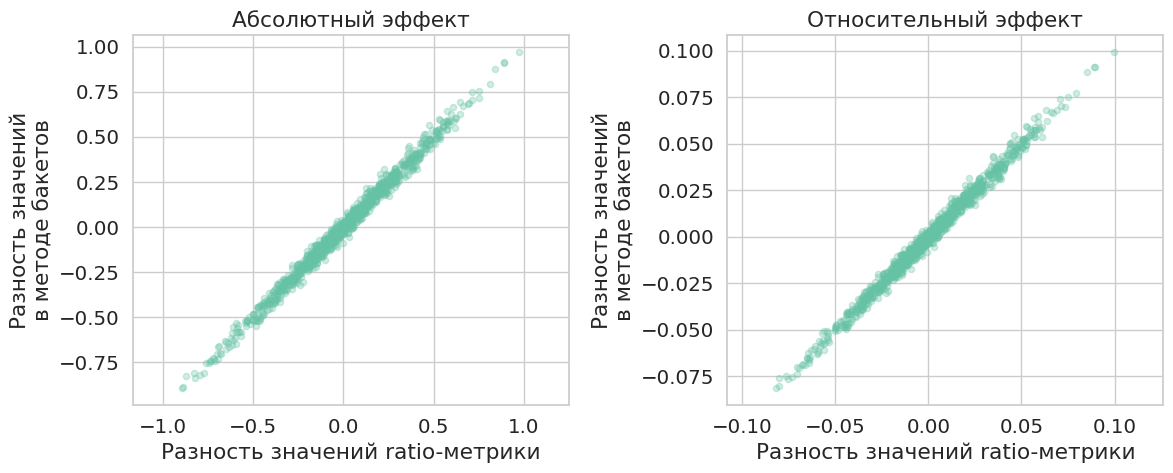

In [14]:
values_absolute, values_relative = metric_sampler(
    generate_session_sample, 
    metrics=[ratio_metric,
             lambda data, numerator_name : bucket_metric(data,
                                                         numerator_name,
                                                         num_buckets=10)], 
    target_name='session_lengths', 
    n_iter=n_iter, 
    sample_size=sample_size
)

plot_difference_metrics(values_absolute, values_relative)

20 бакетов

  0%|          | 0/1000 [00:00<?, ?it/s]

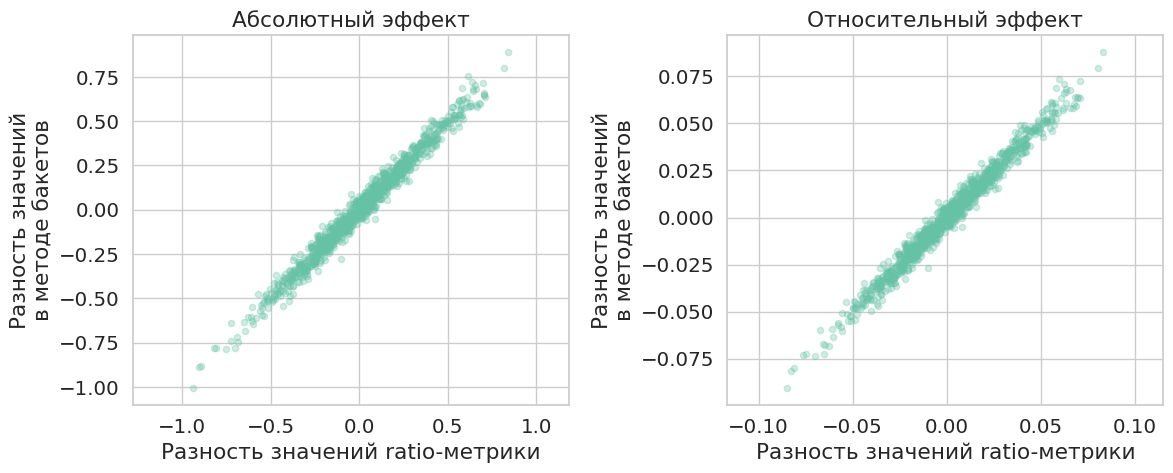

In [15]:
values_absolute, values_relative = metric_sampler(
    generate_session_sample, 
    metrics=[ratio_metric,
             lambda data, numerator_name : bucket_metric(data,
                                                         numerator_name,
                                                         num_buckets=20)], 
    target_name='session_lengths', 
    n_iter=n_iter, 
    sample_size=sample_size
)

plot_difference_metrics(values_absolute, values_relative)

30 бакетов

  0%|          | 0/1000 [00:00<?, ?it/s]

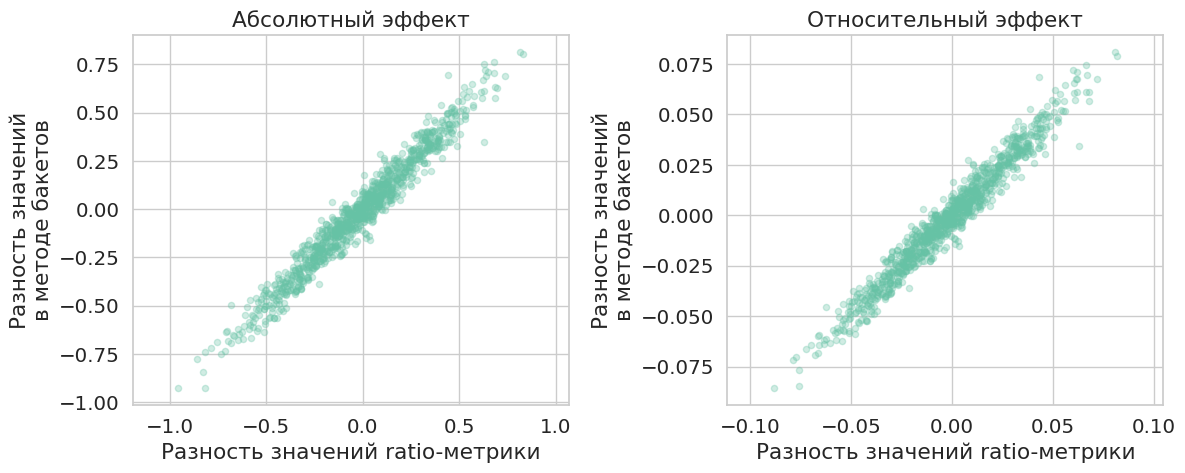

In [16]:
values_absolute, values_relative = metric_sampler(
    generate_session_sample, 
    metrics=[ratio_metric,
             lambda data, numerator_name : bucket_metric(data,
                                                         numerator_name,
                                                         num_buckets=30)], 
    target_name='session_lengths', 
    n_iter=n_iter, 
    sample_size=sample_size
)

plot_difference_metrics(values_absolute, values_relative)

50 бакетов

  0%|          | 0/1000 [00:00<?, ?it/s]

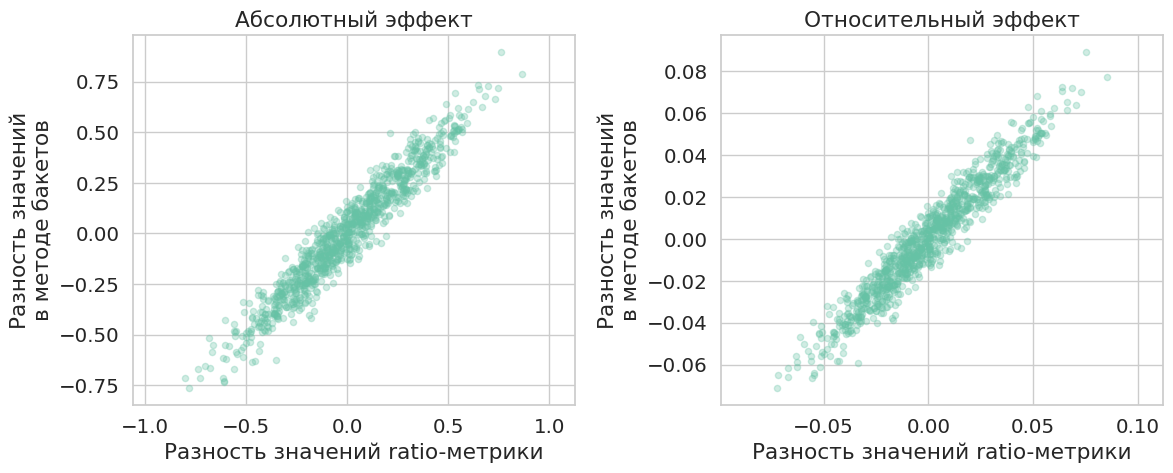

In [17]:
values_absolute, values_relative = metric_sampler(
    generate_session_sample, 
    metrics=[ratio_metric,
             lambda data, numerator_name : bucket_metric(data,
                                                         numerator_name,
                                                         num_buckets=50)], 
    target_name='session_lengths', 
    n_iter=n_iter, 
    sample_size=sample_size
)

plot_difference_metrics(values_absolute, values_relative)

В каком случае можно говорить о приближенной сонаправленности?

В случаях когда 10-20 бакетов - тогда в них достаточно много человек для сонаправленности. Это примерно 1000/10~100 человек в бакете

**2.** Давай все же попробуем сделать CUPED в методе бакетов, может нам зря рассказывали про линеаризацию...

Для начала внедрим CUPED в метод бакетов. Не забудь, что CUPED-преобразование необходимо применять непосредственно к бакетам, а не к исходным пользователям.

*Подсказка.* При определении бакетов удобно сделать группировку по двум полям сразу &mdash; по номеру бакета и по номеру периода. Далее надо будет смерджить горизонтально две части таблицы по периодам, то есть каждый бакет должен быть представлен только одной строкой, в которой будут данные за оба периода.

In [29]:
def generate_session_sample_with_prepilot(
    n_users=100, mean_session_count=15, effect=0
):
    """
    Генерация данных пользовательских сессий для двух последовательных периодов.

    n_users -- количество пользователей
    mean_session_count -- среднее количество сессий на пользователя
    effect -- добавляемый эффект
    """

    # Параметр формы гамма-распределения для каждого пользователя
    user_parameters = np.random.uniform(size=n_users, low=1, high=20)

    # Количество сессий каждого пользователя.
    # Генерируем в два раза больше, чтобы хватило на два периода.
    user_session_counts = 2 + np.random.poisson(
        size=n_users, lam=2 * mean_session_count
    )

    users = []
    period = []
    session_lengths = []

    # Для каждого пользователя генерируем все его сессии
    for user_id in range(n_users):
        users += [f"id_{user_id}"] * user_session_counts[user_id]
        session_lengths += list(
            np.random.gamma(
                shape=user_parameters[user_id],
                size=user_session_counts[user_id],
            )
            + effect
        )

        # В предположении, что все сессии равномерно распределены во времени,
        # количество сессий в каждом периоде имеет биномиальное распределение
        # с параметрами n=кол-во сессий и p=1/2.
        count = np.random.binomial(n=user_session_counts[user_id], p=0.5)

        # Исключаем случаи, когда в одном из периодов нет сессий
        count = min(max(1, count), user_session_counts[user_id] - 1)

        # Определяем периоды
        period += [1] * count
        period += [0] * (user_session_counts[user_id] - count)

    # Заносим в табличку
    data = pd.DataFrame(
        {
            "user_id": users,
            "session_lengths": np.array(session_lengths, dtype=float),
            "period": np.array(period, dtype=int),
        }
    )

    return data

def cuped_transform(
    x_data,
    y_data,
    sample_name="pilot",
    cuped_name="cuped",
    covariate_name="prepilot",
    paired=False,
    return_theta=False,
):
    """
    Выполняет CUPED-преобразование.

    :param x_data, y_data: данные по двум группам
    :param sample_name: имя столбца с целевым признаком
    :param cuped_name: имя столбца, в который записать преобразование
    :param covariate_name: имя столбца-ковариаты
    :param paired: являются ли выборки парными
    :param return_theta: возвращать ли значение theta
    :return: таблицы с добавленными столбцами и theta
    """

    # Случай парных выборок
    if paired:
        theta = (
            np.cov(
                x_data[covariate_name] - y_data[covariate_name],
                x_data[sample_name] - y_data[sample_name],
            )[0, 1]
        ) / ((x_data[covariate_name] - y_data[covariate_name]).var(ddof=0))

    # Случай независимых выборок
    else:
        theta = (
            np.cov(x_data[covariate_name], x_data[sample_name])[0, 1]
            + np.cov(y_data[covariate_name], y_data[sample_name])[0, 1]
        ) / (
            x_data[covariate_name].var(ddof=0)
            + y_data[covariate_name].var(ddof=0)
        )

    # Делаем преобразование
    x_data[cuped_name] = x_data[sample_name] - theta * x_data[covariate_name]
    y_data[cuped_name] = y_data[sample_name] - theta * y_data[covariate_name]

    if return_theta:
        return x_data, y_data, theta
    else:
        return x_data, y_data



Модификация бакетов

In [52]:
def bucket_transform(
    data,
    numerator_name="session_lengths",
    user_name="user_id",
    denominator_name=None,
    num_buckets=10,
):
    """
    Создает бакеты из данных.

    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    num_buckets -- число бакетов

    Возвращает сгруппированные данные
    """

    if denominator_name is None:
        denominator_name = "ratio_denominator"
        data[denominator_name] = 1

    data["bucket"] = data[user_name].apply(lambda x: np.abs(hash(x)) % num_buckets)
    groupped_data = data.groupby(by=["bucket", "period"])[[numerator_name, denominator_name]].sum()
    groupped_data["values"] = (
        groupped_data[numerator_name] / groupped_data[denominator_name]
    )
    final_data = groupped_data["values"].unstack(fill_value=0).rename(columns={0: "values", 1: "values_exp"})
    
    return final_data.reset_index()

def bucket_ratio_ttest(
    control_data,
    test_data,
    cuped=True,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    num_buckets=10,
    alpha=0.05,
):
    """
    Реализация t-test для ratio-метрик с использованием бакетов и CUPED.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    cuped -- применять ли CUPED-преобразование
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    num_buckets -- число бакетов
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue -- соответствующее p-value
    left_bound, right_bound -- границы доверительного интервала
    """
    name = "values_cuped" if cuped else "values_exp"

    control_users_pilot = bucket_transform(data=control_data,
                                           denominator_name=denominator_name,
                                           numerator_name=numerator_name,
                                           num_buckets=num_buckets)
    test_users_pilot = bucket_transform(data=test_data,
                                        denominator_name=denominator_name,
                                        numerator_name=numerator_name,
                                        num_buckets=num_buckets)

    if cuped:
        # Сделаем cuped-преобразование
        control_data, test_data = cuped_transform(
            control_users_pilot,
            test_users_pilot,
            sample_name="values",
            cuped_name=name,
            covariate_name="values_exp",
        )

    else:
        # Если не делаем CUPED, то используем сами данные
        control_data, test_data = control_users_pilot, test_users_pilot

    # Применяем t-test для метрики
    res = sps.ttest_ind(test_data[name], control_data[name])
    stat = res.statistic
    pvalue = res.pvalue

    # дов. интервал линеаризованной метрики
    left_bound, right_bound = res.confidence_interval()

    return stat, pvalue, left_bound, right_bound

def test_simulation(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
):
    """
    Проведение одного теста на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости

    Возвращает: доверительный интервал
    """

    # Генерируем выборки
    control_data = generate_sample_control(size=sample_size)
    test_data = generate_sample_test(size=sample_size)

    # Добавляем эффект, если хотим оценить мощность
    if relative_effect:
        test_data[feature_values] *= 1 + effect * (test_data["period"] == 1)
    else:
        test_data[feature_values] += effect * (test_data["period"] == 1)

    # Применяем критерий
    return test(control_data, test_data)[1]


def run_experiments(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
    n_iter=10_000,
    sample_size=1_000,
    alpha=0.05,
    draw=True,
    show_pvals=True,
    n_jobs=-1,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    draw -- рисовать ли график
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    """

    if generate_sample_test is None:
        generate_sample_test = generate_sample_control

    pvals = Parallel(n_jobs=n_jobs)(
        delayed(test_simulation)(
            test,
            generate_sample_control,
            generate_sample_test,
            feature_values,
            effect,
            relative_effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )
    n_rejects = (np.array(pvals) < alpha).sum()

    # Оценка вероятности ошибки первого рода
    type_1_prob_est, left_bound, right_bound = estimate_reject_prob(
        n_rejects, n_iter
    )

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            type_1_prob_est,
            left_bound,
            right_bound,
            show_pvals=show_pvals,
            pvals=pvals,
            alpha=alpha,
            figsize=figsize,
        )

    return type_1_prob_est, (left_bound, right_bound)

Теперь провалидируем применение CUPED в методе бакетов на предмет контролирования ошибки 1 рода. Как и раньше, бери какую-нибудь функцию AA-теста с занятия.

*Не забудь, что итерации валидации можно легко параллелить, а ведь их надо сделать достаточно большое количество.*

Валидация бакетов + CUPED (на 10 бакетах)

  0%|          | 0/1000 [00:00<?, ?it/s]

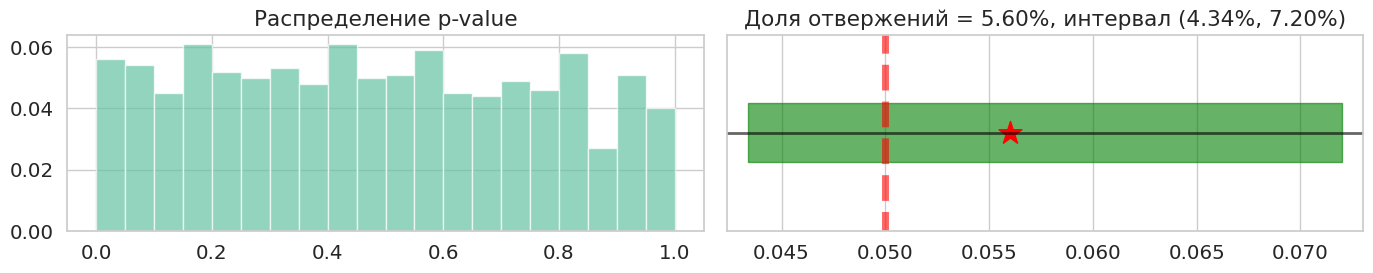

(0.056, (0.043374813385441996, 0.07202334814973096))

In [44]:
run_experiments(
    test=lambda x, y: bucket_ratio_ttest(x, y,
                                         cuped=True,
                                         num_buckets=10),
    generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
    sample_size=sample_size,
    n_iter=1000,
)

На 20 бакетах

  0%|          | 0/1000 [00:00<?, ?it/s]

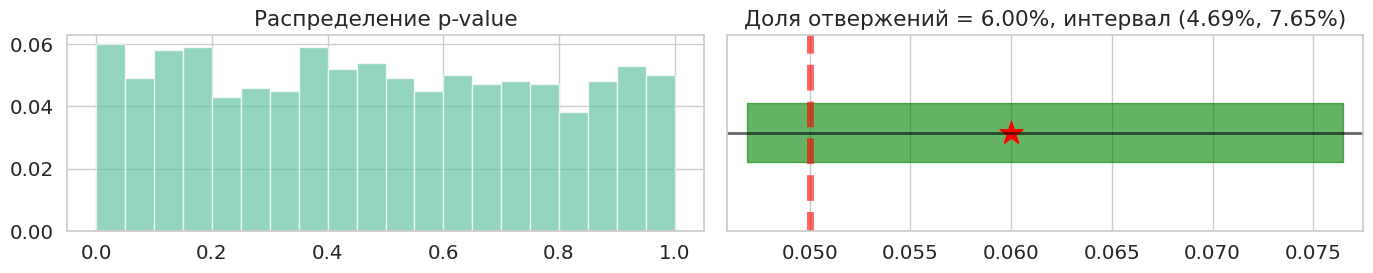

(0.06, (0.04689647267593195, 0.07647107479135656))

In [45]:
run_experiments(
    test=lambda x, y: bucket_ratio_ttest(x, y,
                                         cuped=True,
                                         num_buckets=20),
    generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
    sample_size=sample_size,
    n_iter=1000,
)

Для какого количества бакетов выполнены одновременно первые два условия из перечисленных вначале задачи?

Для ответа на этот вопрос еще надо провалидировать эти самые 10 и 20 бакетов и без CUPED

  0%|          | 0/1000 [00:00<?, ?it/s]

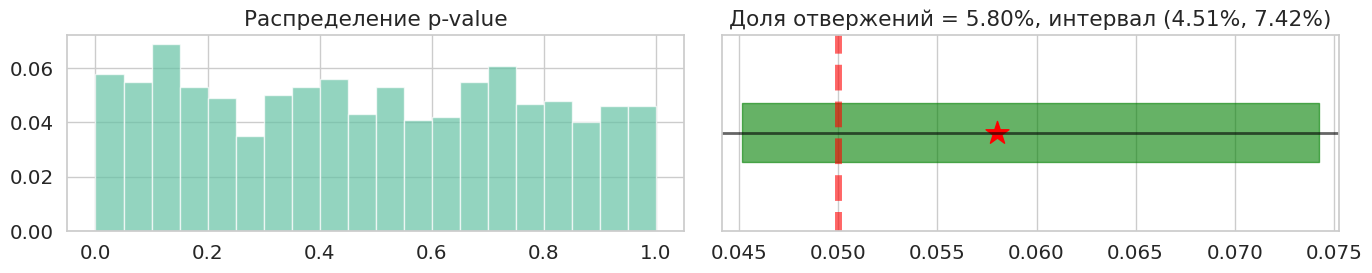

(0.058, (0.04513327823499824, 0.0742495762662325))

In [46]:
run_experiments(
    test=lambda x, y: bucket_ratio_ttest(x, y,
                                         cuped=False,
                                         num_buckets=20),
    generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
    sample_size=sample_size,
    n_iter=1000,
)

Теперь для 10

  0%|          | 0/1000 [00:00<?, ?it/s]

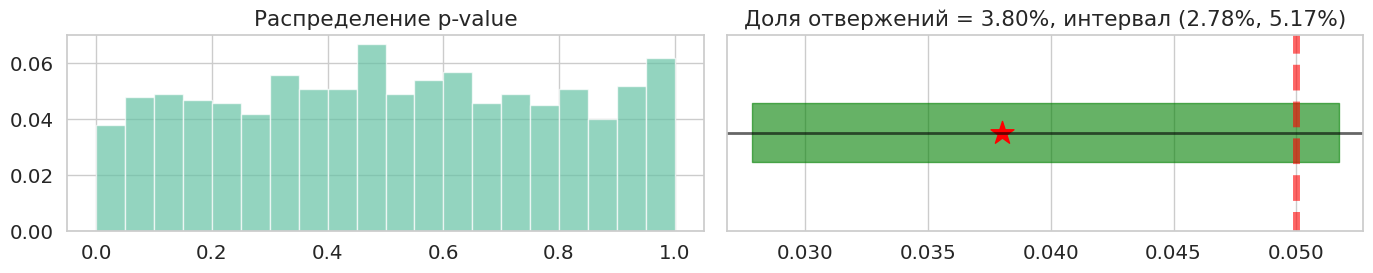

(0.038, (0.027809004509302626, 0.05172692033135032))

In [48]:
run_experiments(
    test=lambda x, y: bucket_ratio_ttest(x, y,
                                         cuped=False,
                                         num_buckets=10),
    generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
    sample_size=sample_size,
    n_iter=1000,
)

Все корректно -> для 10 и 20 бакетов условия выполнены

Но 10 бакетов выглядят сильно поприличнее - берем только их

**3.** Если такие случаи нашлись, оцени мощность соответствующих тестов для размеров эффекта от 1% до 5%. Сравни ее с CUPED в методе линеаризации.

*Хм, кажется, или здесь тоже только код позапускать?*

In [76]:
def relative_var(mean1, mean2, var1, var2, cov):
    """Формула дисперсии относительного t-test"""

    return (
        var1 / mean2**2
        + var2 * mean1**2 / mean2**4
        - 2 * cov * mean1 / mean2**3
    )

def ratio_var(data, numerator_name, denominator_name, user_name):
    '''
    Оценка асимптотической дисперсии ratio-метрики.
    
    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    '''
    
    user_sums = data.groupby(user_name).sum()
    
    mean1, mean2 = user_sums.mean().loc[[numerator_name, denominator_name]]
    var1, var2 = user_sums.var().loc[[numerator_name, denominator_name]] / len(user_sums)
    cov = user_sums.cov().loc[numerator_name, denominator_name] / len(user_sums)
    
    return relative_var(mean1, mean2, var1, var2, cov)

def delta_ratio_ttest(
    x_data, y_data, 
    numerator_name='session_lengths', 
    denominator_name=None, 
    user_name='user_id',
    alpha=0.05
):
    '''
    Реализаця t-test для ratio-метрики через ее асимптотическую дисперсию, 
    полученную с помощью дельта-метода.
    
    Аргументы:
    x_data, y_data -- выборки одинакового размера
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    alpha -- уровень значимости
    
    Возвращает:
    stat -- статистика критерия
    left_bound, right_bound -- границы дов. интервала
    pvalue
    '''
    
    if denominator_name is None:
        denominator_name = 'ratio_denominator'
        x_data[denominator_name] = 1
        y_data[denominator_name] = 1
        
    # Оценка мат. ожиданий ratio-метрик
    x_mean = ratio_metric(x_data, numerator_name, denominator_name)
    y_mean = ratio_metric(y_data, numerator_name, denominator_name)
    
    # Оценка дисперсий ratio-метрик
    x_var = ratio_var(x_data, numerator_name, denominator_name, user_name=user_name)
    y_var = ratio_var(y_data, numerator_name, denominator_name, user_name=user_name)
    
    # Далее формируем обычный t-test
    stat = x_mean - y_mean
    var = x_var + y_var
    std = np.sqrt(var)
    
    z_stat = stat / std
    pvalue = 2*sps.norm.sf(np.abs(z_stat))
    
    q = sps.norm.ppf(1 - alpha/2)
    left_bound = stat - q*std
    right_bound = stat + q*std
    
    return stat, pvalue, left_bound, right_bound

def linearization(
    control_data,
    test_data,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
):
    """
    Реализация линеаризации ratio-метрики.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации

    Возвращает:
    control_users, test_users -- таблицу с поюзерными линеаризованными метриками,
    которые записаны в колонках linearization_values
    """

    if denominator_name is None:
        control_data = control_data.copy()
        test_data = test_data.copy()

        denominator_name = "ratio_denominator"
        control_data[denominator_name] = 1
        test_data[denominator_name] = 1

    # Коэффициент линеаризации
    kappa = (1 - eta) * ratio_metric(
        control_data, numerator_name, denominator_name
    ) + eta * ratio_metric(test_data, numerator_name, denominator_name)

    # Группируем по пользователям
    control_users = control_data.groupby(user_name).sum()
    test_users = test_data.groupby(user_name).sum()

    # Вычисляем линеаризованные метрики
    control_users["linearization_values"] = (
        control_users[numerator_name] - kappa * control_users[denominator_name]
    )
    test_users["linearization_values"] = (
        test_users[numerator_name] - kappa * test_users[denominator_name]
    )

    return control_users, test_users

def linearization_ratio_ttest(
    control_data,
    test_data,
    cuped=True,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
    alpha=0.05,
):
    """
    Реализация t-test для ratio-метрик с использованием линеаризации и CUPED.
    В качестве ковариаты используется значение линеаризованной метрики на предпериоде.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    cuped -- применять ли CUPED-преобразование
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue -- соответствующее p-value
    left_bound, right_bound -- границы доверительного интервала
    """

    denom = "ratio_denominator" if denominator_name is None else denominator_name
    name = "linearization_values_cuped" if cuped else "linearization_values"

    # Линеаризация на экспериментальном периоде
    control_users_pilot, test_users_pilot = linearization(
        control_data[control_data["period"] == 1],
        test_data[test_data["period"] == 1],
        numerator_name=numerator_name,
        denominator_name=denominator_name,
        user_name=user_name,
        eta=eta,
    )

    if cuped:
        # Линеаризация на предэкспериментальном периоде
        control_users_prepilot, test_users_prepilot = linearization(
            control_data[control_data["period"] == 0],
            test_data[test_data["period"] == 0],
            numerator_name=numerator_name,
            denominator_name=denominator_name,
            user_name=user_name,
            eta=eta,
        )

        # Соединяем две таблицы данных для каждой из групп
        control_users_pilot = control_users_pilot.join(
            control_users_prepilot, lsuffix="", rsuffix="_prepilot"
        )
        test_users_pilot = test_users_pilot.join(
            test_users_prepilot, lsuffix="", rsuffix="_prepilot"
        )

        # Сделаем cuped-преобразование
        control_data, test_data = cuped_transform(
            control_users_pilot,
            test_users_pilot,
            sample_name="linearization_values",
            cuped_name=name,
            covariate_name="linearization_values_prepilot",
        )

    else:
        # Если не делаем CUPED, то используем сами линеаризованные данные
        control_data, test_data = control_users_pilot, test_users_pilot

    # Применяем t-test для линеаризованной метрики
    res = sps.ttest_ind(test_data[name], control_data[name])
    stat = res.statistic
    pvalue = res.pvalue

    # дов. интервал линеаризованной метрики
    left_bound, right_bound = res.confidence_interval()

    # по теореме с занятия дов. интервал исходной метрики
    # пропорционален линеаризованной метрике
    coef = eta * control_data[denom].mean() + (1 - eta) * test_data[denom].mean()
    left_bound /= coef
    right_bound /= coef

    return stat, pvalue, left_bound, right_bound

Сравним

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

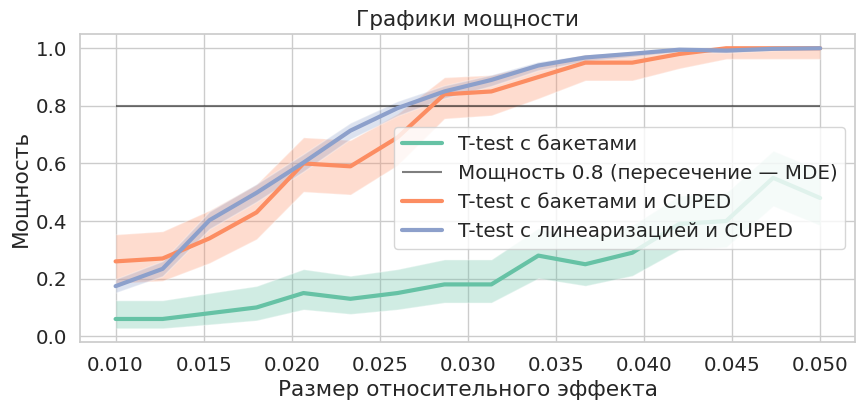

In [53]:
effects_list = np.linspace(0.01, 0.05, 16)
powers = np.zeros(len(effects_list))
left_bounds = np.zeros(len(effects_list))
right_bounds = np.zeros(len(effects_list))

for i, effect in tqdm(enumerate(effects_list), leave=False):
    powers[i], (left_bounds[i], right_bounds[i]) = run_experiments(
        test=lambda x, y: bucket_ratio_ttest(x, y, cuped=False, num_buckets=10),
        generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
        effect=effect,
        sample_size=sample_size,
        n_iter=100,
        draw=False,
    )

draw_power(
    powers,
    left_bounds,
    right_bounds,
    label="T-test с бакетами",
    new_figure=True,
    effects_list=effects_list,
)


effects_list = np.linspace(0.01, 0.05, 16)
powers = np.zeros(len(effects_list))
left_bounds = np.zeros(len(effects_list))
right_bounds = np.zeros(len(effects_list))

for i, effect in tqdm(enumerate(effects_list), leave=False):
    powers[i], (left_bounds[i], right_bounds[i]) = run_experiments(
        test=lambda x, y: bucket_ratio_ttest(x, y, cuped=True, num_buckets=10),
        generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
        effect=effect,
        sample_size=sample_size,
        n_iter=100,
        draw=False,
    )

draw_power(
    powers,
    left_bounds,
    right_bounds,
    label="T-test с бакетами и CUPED",
    new_figure=False,
    effects_list=effects_list,
)

effects_list = np.linspace(0.01, 0.05, 16)
powers = np.zeros(len(effects_list))
left_bounds = np.zeros(len(effects_list))
right_bounds = np.zeros(len(effects_list))

for i, effect in tqdm(enumerate(effects_list), leave=False):
    powers[i], (left_bounds[i], right_bounds[i]) = run_experiments(
        test=lambda x, y: linearization_ratio_ttest(x, y, cuped=True, eta=0.5),
        generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
        effect=effect,
        sample_size=sample_size,
        n_iter=100,
        draw=False,
    )

draw_power(
    powers,
    left_bounds,
    right_bounds,
    label="T-test с линеаризацией и CUPED",
    new_figure=False,
    effects_list=effects_list,
)

**Выводы:** 

CUPED увеличивает мощность, итого примерно такая же мощность, как с линеаризацией и CUPED

**Ответ:** Устал переписывать код, если честно. Тут скорее чисто технически взять и перелапатить часть функций с семинара.

---

### Задача 2.

Нам показалось, что задач очень мало, ведь тут столько всего интересного, хотя мы представили твою реакцию :)

Итак, вот еще одна задачка, но она *короткая и очень простая*, честно-честно. На лекции была получена связь между разницей линеаризованной метрики $\Delta L$ и исходной ratio-метрики $\Delta R$. Это соотношение позволяет в методе линеаризации получать доверительный интервал эффекта по исходной ratio-метрики так, как показано в ноутбуке с занятия. И на занятии мы даже проверили корректность такого подхода с точки зрения вероятности ошибки I рода и мощности.

Однако, давай проверим, насколько таким интервалом можно оценить истинный эффект. Для этого можно использовать следующие показатели качества:
* доля покрытия интервалом истинного значения параметра,
* средняя длина доверительного интервала.

Например, в первом случае нужно сравнить интервал не с нулем, как в ноутбуке, а с непосредственно истинным значением эффекта. Во втором случае &mdash; просто взять разность границ интервалов и усреднить.



Возьми с занятия код функции `run_experiments` и модифицируй ее так, чтобы после итераций оставались только границы доверительных интервалов. Далее посчитай указанные выше показатели качества. Это можно сделать внутри функции, а можно попросить ее вернуть список всех интервалов и все посчитать уже после.

Выполни это со следующими тестами:
* линеаризация,
* линеаризация + CUPED,
* дельта-метод.

*Ты же понимаешь, что по сути нужно выполнить ровно те же итерации, только брать не p-value, а доверительный интервал? Внутри функции даже всю визуализацию можно убрать.*

*Указания*:
* Учти, что в реализации теста через дельта-метод мы не фильтровали данные по периоду. Если ты берешь генерацию данных с периодами, не забудь сделать фильтрацию.
* Для интерпретации можно использовать как абсолютные, так и относительные эффекты при генерации данных. Однако, линеаризация не совместима с относительным тестом, потому как линеаризованная метрика может принимать разные знаки. Поэтому оценивать нужно только абсолютные эффекты. Если на генерации использовали относительные, не забудьте их перевести в абсолютные при сравнении интервалов.
* Сделай сравнение как для маленьких, так и для больших эффектов. Из теоремы с лекции мы помним, что для больших эффектов линеаризованная метрика может отклоняться от показателей исходной ratio-метрики.

In [77]:
def test_simulation(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
):
    """
    Проведение одного теста на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости

    Возвращает: доверительный интервал
    """

    # Генерируем выборки
    control_data = generate_sample_control(size=sample_size)
    test_data = generate_sample_test(size=sample_size)

    if "period" in test_data:
        mask = test_data["period"] == 1
    else:
        mask = slice(None) 

    if relative_effect:
        test_data.loc[mask, feature_values] *= 1 + effect
    else:
        test_data.loc[mask, feature_values] += effect

    return test(control_data, test_data)

def run_experiments(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
    n_iter=10_000,
    sample_size=1_000,
    alpha=0.05,
    n_jobs=-1,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
      test -- статистический критерий;
      generate_sample_control, generate_sample_test -- функции для семплирования выборок;
      n_iter -- количество итераций;
      sample_size -- размер выборок;
      alpha -- теоретический уровень значимости;
      effect -- истинное значение эффекта, используемое для проверки покрытия интервалом;
      relative_effect -- флаг, определяющий относительный эффект или абсолютный.

    Возвращает:
      coverage_fraction -- доля доверительных интервалов, содержащих истинное значение эффекта;
      avg_length -- средняя длина доверительного интервала;
      intervals -- список кортежей (left_bound, right_bound) для каждого эксперимента.
    """
    if generate_sample_test is None:
        generate_sample_test = generate_sample_control

    results = Parallel(n_jobs=n_jobs)(
        delayed(test_simulation)(
            test,
            generate_sample_control,
            generate_sample_test,
            feature_values,
            effect,
            relative_effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )

    intervals = [(res[2], res[3]) for res in results]

    coverages = [1 if (lb <= effect <= rb) else 0 for lb, rb in intervals]
    coverage_fraction = np.mean(coverages)

    lengths = [rb - lb for lb, rb in intervals]
    avg_length = np.mean(lengths)

    return coverage_fraction, avg_length, intervals

Теперь просто визуализируй полученные значения, сравни интервалы и сделай выводы.

In [103]:
test_list = [
    lambda x, y: linearization_ratio_ttest(x, y, cuped=False, eta=0.5),
    lambda x, y: linearization_ratio_ttest(x, y, cuped=True, eta=0.5),
    lambda x, y: delta_ratio_ttest(y, x),
]

data_sample_list = [
    lambda size: generate_session_sample_with_prepilot(size),
    lambda size: generate_session_sample_with_prepilot(size),
    lambda size: generate_session_sample(size)
]

title_list = [
    'T-test с линеаризацией',
    'T-test с линеаризацией и CUPED',
    'T-test с дельта-методом'
]

results = {}

effects =  np.concatenate((np.arange(0, 5, 1),
                           np.arange(10, 16, 1),
                           np.arange(50, 56, 1)))

for test, title, sample_func in tqdm(zip(test_list, title_list, data_sample_list)):
    results[title] = {"coverage": [], "avg_length": []}
    for effect in effects:
        coverage, avg_length, _ = run_experiments(
            test,
            generate_sample_control=sample_func,
            effect=effect,
            sample_size=1000,
            relative_effect=False,
            n_iter=100
        )
        results[title]["coverage"].append(coverage)
        results[title]["avg_length"].append(avg_length)

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Итого

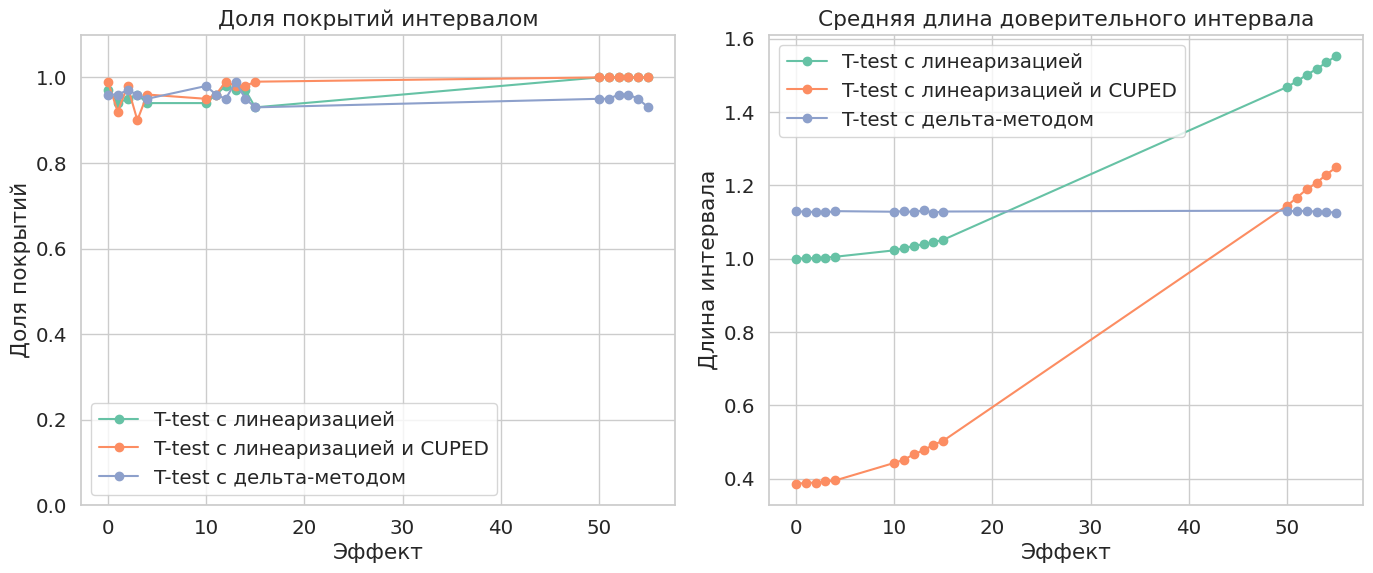

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for title in title_list:
    axes[0].plot(effects, results[title]["coverage"], marker='o', label=title)

axes[0].set_title("Доля покрытий интервалом")
axes[0].set_xlabel("Эффект")
axes[0].set_ylabel("Доля покрытий")
axes[0].set_ylim(0, 1.1)
axes[0].legend()

for title in title_list:
    axes[1].plot(effects, results[title]["avg_length"], marker='o', label=title)

axes[1].set_title("Средняя длина доверительного интервала")
axes[1].set_xlabel("Эффект")
axes[1].set_ylabel("Длина интервала")
axes[1].legend()

plt.tight_layout()
plt.show()

Вывод:

На линеаризованных метриках интервал покрывает эффект корректно, но за счет роста длины интервала. Дельта метод ведет себя абсолютно стабильно. При этом на маленьких эффектах CUPED и просто лианеризация выигрывают дельта метод, причем первый из них очень мощный.

Для того, чтобы рассчет был не слишком долгим, пришлось рассчитывать только на ключевых точках

Правда простая задача?)

Ответ: Дельта метод с семинара оказался, похоже, с ошибкой, пришлось дебажить

---

### Задача 3.

Отлично, впереди все самое интересное &mdash; реальные данные! Вспомни, ранее мы делали дизайн АБ-теста на сайте Физтех.Статистики, причем в качестве метрики использовали среднюю по посетителям глубину просмотра страниц. Однако, на практике заказчики чаще интересуются глубиной просмотра страниц в среднем по всем посетителям сразу. Эту метрику мы и рассмотрим в данной задаче.

Поясни, почему она является ratio-метриками, и укажи, что в числителе, а что в знаменателе.

Аналогично рассмотри метрику длительности веб-сессий по всему сайту.

1) Средняя глубина просмотра (в сессию) = общее число просмотренных страниц / общее число сессий
2) Средняя длительность сессии = общее время просмотра страниц / общее число сессий

Потому как это отношение двух метрик, то это ratio-метрика

**1.** Хм, а если это ratio-метрики, правильно ли мы с ними работали? Давай проверим сонаправленность на реальных данных. Проверку нужно выполнить аналогично AA-тесту, совершая следующие итерации.
1. Выбрать случайный интервал времени фиксированной длины в истории визитов.
2. Выбрать две случайные группы фиксированного размера.
3. Посчитать по ним ratio-метрику и исследуемую метрику.

*Правда ведь просто? Ну разве что выбор момента времени и группы надо дописать.*

Проведи эту проверку для длительности и глубины (можно в одном цикле) для следующих подходов:
- агрегация данных по пользователям,
- метод бакетов,
- линеаризация.

Все эти способы рассматривались на занятии, так что это еще один повод туда заглянуть. Напомним, ratio-метрика считается как общее отношение, без агрегации по пользователям.

Выполни всю эту процедуру для двух разных размеров групп и двух разных длин интервалов. Например, 10% и 20% пользователей, а так же 3 и 5 недель.

In [118]:
test_control_size = 10_000  # пользователей в тесте+контроле
fraq_test = 0.5  # доля пользователей в тесте

# зададим промежуток времени, на котором валидируем
date_valid_start = pd.to_datetime("2024-01-01")
date_valid_end = pd.to_datetime("2024-02-29")
# зададим длительность теста
test_dlit = 3*7
# целевая метрика
target_column = "pageViews"

# размеры эффектов для оценки мощности
effects_list = np.linspace(0, 0.15, 16)

n_iter = 1_000  # количество итераций валидации
alpha = 0.05  # уровень значимости
n_jobs = -1  # количество параллельных потоков

Считываем данные

In [120]:
data = pd.read_csv("miptstats_metrica.tsv", sep="\t")
for column in data.columns:
    col = column.replace("ym:s:", "")
    data.rename(columns={column: col}, inplace=True)
data["dateTimeUTC"] = pd.to_datetime(data["dateTimeUTC"])
data["date"] = pd.to_datetime(data["dateTimeUTC"].dt.date)

data.head(5)

,visitID,clientID,dateTimeUTC,startURL,endURL,pageViews,visitDuration,isNewUser,bounce,regionCountry,...,mobilePhone,operatingSystemRoot,browser,browserEngine,screenOrientation,screenWidth,screenHeight,windowClientWidth,windowClientHeight,date
0,1.801686e+19,1568056026568729022,2020-01-01 03:28:50,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,1,0,1,Russia,...,NaN,gnu_linux,chrome,WebKit,2,1920,1080,1905,981,2020-01-01
1,1.802359e+19,1577864187752491163,2020-01-01 10:36:27,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,9,215,1,0,Singapore,...,apple,ios_double,safari_mobile,WebKit,1,375,667,375,559,2020-01-01
2,1.802460e+19,1567765219104836417,2020-01-01 11:40:44,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,88,0,0,Russia,...,apple,ios_double,yandex_browser,WebKit,1,414,736,414,660,2020-01-01
3,1.802475e+19,1576839432510419026,2020-01-01 11:50:13,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,19,0,0,China,...,samsung,android,chromemobile,WebKit,1,412,892,412,756,2020-01-01
4,1.802518e+19,1576246599115183097,2020-01-01 12:17:33,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,2,0,0,Russia,...,NaN,gnu_linux,firefox,Gecko,2,1920,1080,913,942,2020-01-01


Функции

In [227]:
def generate_subarray(
    data,
    date_valid_start=date_valid_start,
    date_valid_end=date_valid_end,
    test_dlit=test_dlit,
    test_control_size=test_control_size,
    fraq_test=fraq_test,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
):
    """
    Генерация выборок 2-x групп посредством случайного деления пользователей на 2 группы
    Агрегация данных по пользователям

    Аргументы:
    data -- данные
    date_valid_start, date_valid_end -- временные границы валидации
    test_dlit -- длительность истории, которую берем в тест
    test_control_size -- размер теста+контроля
    fraq_test -- доля тестовой группы

    Возвращает:
    test_groupped, control_groupped -- сгруппированные данные по тесту и контролю
    """
    # определяем временные границы теста
    all_days = (date_valid_end - date_valid_start).days - test_dlit
    diff_from_start = np.random.choice(all_days, 1)[0]
    start_date = date_valid_start + pd.to_timedelta(diff_from_start, "D")
    end_date = start_date + pd.to_timedelta(test_dlit, "D")

    # берем нужный срез данных по времени
    data_start_end = data[
        (data[date_column] >= start_date) & (data[date_column] < end_date)
    ]

    # из всех пользователей выбираем тест и контроль
    users = data_start_end[user_column].unique()
    test_size = int(test_control_size * fraq_test)
    control_size = test_control_size - test_size
    test_users = np.random.choice(users, test_size, replace=False)
    other_users = list(set(users) - set(test_users))
    control_users = np.random.choice(
        other_users, min(control_size, len(other_users)), replace=False
    )

    # берем нужный срез данных по пользователям
    test = data_start_end[data_start_end[user_column].isin(test_users)]
    control = data_start_end[data_start_end[user_column].isin(control_users)]

    return test, control

def ratio_metric(data, numerator_name, denominator_name=None):
    """
    Вычисляет ratio-метрику

    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    if denominator_name is None:
        return data[numerator_name].mean()
    else:
        return data[numerator_name].sum() / data[denominator_name].sum()


def users_mean_metric(
    data, numerator_name, user_name="clientID", denominator_name=None
):
    """
    Вычисляет метрики отдельно по пользователям

    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """
    cols_to_group = [user_name, numerator_name]
    if denominator_name:
        cols_to_group.append(denominator_name)
    
    filtered_data = data[cols_to_group]

    groupped_data = filtered_data.groupby(user_name)

    if denominator_name is None:
        return groupped_data.mean()[numerator_name].mean()
    else:
        users_values = (
            groupped_data[numerator_name].sum()
            / groupped_data[denominator_name].sum()
        )
        return users_values.mean()

def bucket_transform(
    data,
    numerator_name="pageViews",
    user_name="clientID",
    denominator_name=None,
    num_buckets=10,
):
    """
    Создает бакеты из данных.

    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    num_buckets -- число бакетов

    Возвращает сгруппированные данные
    """
    if denominator_name is None:
        denominator_name = "ratio_denominator"
        data[denominator_name] = 1

    data["bucket"] = data[user_name].apply(lambda x: np.abs(hash(x)) % num_buckets)
    groupped_data = data.groupby(by="bucket")[[numerator_name, denominator_name]].sum()
    groupped_data["values"] = (
        groupped_data[numerator_name] / groupped_data[denominator_name]
    )
    return groupped_data
    
def bucket_metric(
    data, numerator_name, user_name="clientID", denominator_name=None,
    num_buckets=10
):
    """
    Вычисляет метрики отдельно по бакетам

    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    bucket_data = bucket_transform(
        data,
        numerator_name,
        user_name=user_name,
        denominator_name=denominator_name,
        num_buckets=num_buckets,
    )

    return bucket_data["values"].mean()

def linearization(
    control_data,
    test_data,
    numerator_name="pageViews",
    denominator_name=None,
    user_name="clientID",
    eta=0,
):
    """
    Реализация линеаризации ratio-метрики.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации

    Возвращает:
    control_users, test_users -- таблицу с поюзерными линеаризованными метриками,
    которые записаны в колонках linearization_values
    """
    cols_to_group = [user_name, numerator_name]
    if denominator_name:
        cols_to_group.append(denominator_name)
    
    control_data = control_data[cols_to_group]
    test_data = test_data[cols_to_group]
    
    if denominator_name is None:
        control_data = control_data.copy()
        test_data = test_data.copy()

        denominator_name = "ratio_denominator"
        control_data[denominator_name] = 1
        test_data[denominator_name] = 1

    # Коэффициент линеаризации
    kappa = (1 - eta) * ratio_metric(
        control_data, numerator_name, denominator_name
    ) + eta * ratio_metric(test_data, numerator_name, denominator_name)

    # Группируем по пользователям
    control_users = control_data.groupby(user_name).sum()
    test_users = test_data.groupby(user_name).sum()

    # Вычисляем линеаризованные метрики
    control_users["linearization_values"] = (
        control_users[numerator_name] - kappa * control_users[denominator_name]
    )
    test_users["linearization_values"] = (
        test_users[numerator_name] - kappa * test_users[denominator_name]
    )

    return control_users, test_users

def linearization_metric(data, numerator_name):
    return data["linearization_values"].mean()

def metric_sampler(
    generate_sample, metrics, target_name,
    test_dlit=3*7,
    n_iter=10000, sample_size=1000,
    is_linearization=False
):
    """
    Генерация значений разности средних по группам для разных метрик.

    Аргументы:
    generate_sample -- функции для семплирования выборок
    metrics -- список метрик
    target_name -- поле для вычисления метрики
    test_dlit -- время за которое берутся измерения
    n_iter -- количество итераций
    sample_size -- размер выборок
    is_linearization -- делать ли линеаризацию
    """

    values_absolute = np.zeros((len(metrics), n_iter))
    values_relative = np.zeros((len(metrics), n_iter))

    # Проведение экспериментов
    for i in tqdm(range(n_iter), leave=False):
        test, control = generate_sample(data=data,
                                       test_control_size=sample_size,
                                       test_dlit=test_dlit)

        if is_linearization:
            control_lin, test_lin = linearization(control, test, numerator_name=target_name, eta=0)
            for j, (metric, control_value, test_value) in enumerate(
                zip([ratio_metric, linearization_metric], [control, control_lin], [test, test_lin])
            ):
                test_metric = metric(test_value, target_name)
                control_metric = metric(control_value, target_name)
                values_absolute[j, i] = test_metric - control_metric
                values_relative[j, i] = (test_metric - control_metric) / control_metric
        
        else:
            for j, metric in enumerate(metrics):
                test_metric = metric(test, numerator_name=target_name)
                control_metric = metric(control, numerator_name=target_name)
                values_absolute[j, i] = test_metric - control_metric
                values_relative[j, i] = (test_metric - control_metric) / control_metric

    return values_absolute, values_relative


Графики

In [201]:
def plot_comparison_grid(targets, sample_sizes, test_dlits,
                         limited=False, n_iter=200):
    colors = {'bucket': 'royalblue', 'users_mean': 'green', 'linearization': 'crimson'}
    
    for target in targets:
        for effect_type, effect_idx in [('Абсолютный эффект', 0), ('Относительный эффект', 1)]:
            fig, axs = plt.subplots(len(sample_sizes), len(test_dlits), 
                             figsize=(24, 12), squeeze=False)
            fig.suptitle(f'{target}\n{effect_type}', fontsize=20, y=1.02)
            
            for row, sample_size in enumerate(sample_sizes):
                for col, test_dlit in enumerate(test_dlits):
                    ax = axs[row, col]
                    y_min, y_max = float('inf'), float('-inf')
                    
                    # Собираем данные для всех методов
                    for method, metric, is_linear in [
                        ('bucket', lambda data, numerator_name: bucket_metric(data, numerator_name, num_buckets=10), False),
                        ('users_mean', users_mean_metric, False),
                        ('linearization', linearization_metric, True)
                    ]:
                        values_abs, values_rel = metric_sampler(
                            generate_subarray,
                            metrics=[ratio_metric, metric],
                            target_name=target,
                            n_iter=n_iter,
                            sample_size=sample_size,
                            test_dlit=test_dlit,
                            is_linearization=is_linear
                        )

                        effect = values_abs if effect_idx == 0 else values_rel
                        if method == 'bucket':
                            y_min = min(y_min, min(effect[1]))
                            y_max = max(y_max, max(effect[1]))
                            
                        ax.scatter(effect[0], effect[1], 
                                  color=colors[method],
                                  s=30, alpha=0.4, 
                                  label=method.capitalize())
                    y_margin = (y_max - y_min) * 0.1 if y_max > y_min else 0.01
                    ax.set_ylim(y_min - y_margin, y_max + y_margin)
                    ax.set_title(f'N={sample_size}, Дни={test_dlit}', fontsize=20)
                    ax.set_xlabel('Разность ratio-метрики', fontsize=20)
                    ax.set_ylabel('Разность метода', fontsize=20)
                    ax.tick_params(axis='both', labelsize=20)
                    ax.grid(alpha=0.2)
                    ax.axis('equal')
                    ax.axhline(0, color='black', linestyle='--',
                               linewidth=0.5, alpha=0.7)
                    ax.axvline(0, color='black', linestyle='--',
                               linewidth=0.5, alpha=0.7)

                    if limited:
                        ax.set_ylim(y_min - y_margin, y_max + y_margin)
                    
                    if row == 0 and col == 0:
                        ax.legend(fontsize=20, markerscale=3)

            plt.tight_layout()
            plt.show()

Пострался сделать красивые графики. N - общий размер выборок (тест + контроль). С ограничением по осям (относительный эффект из-за лианеризации сильно вытягивает график):

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

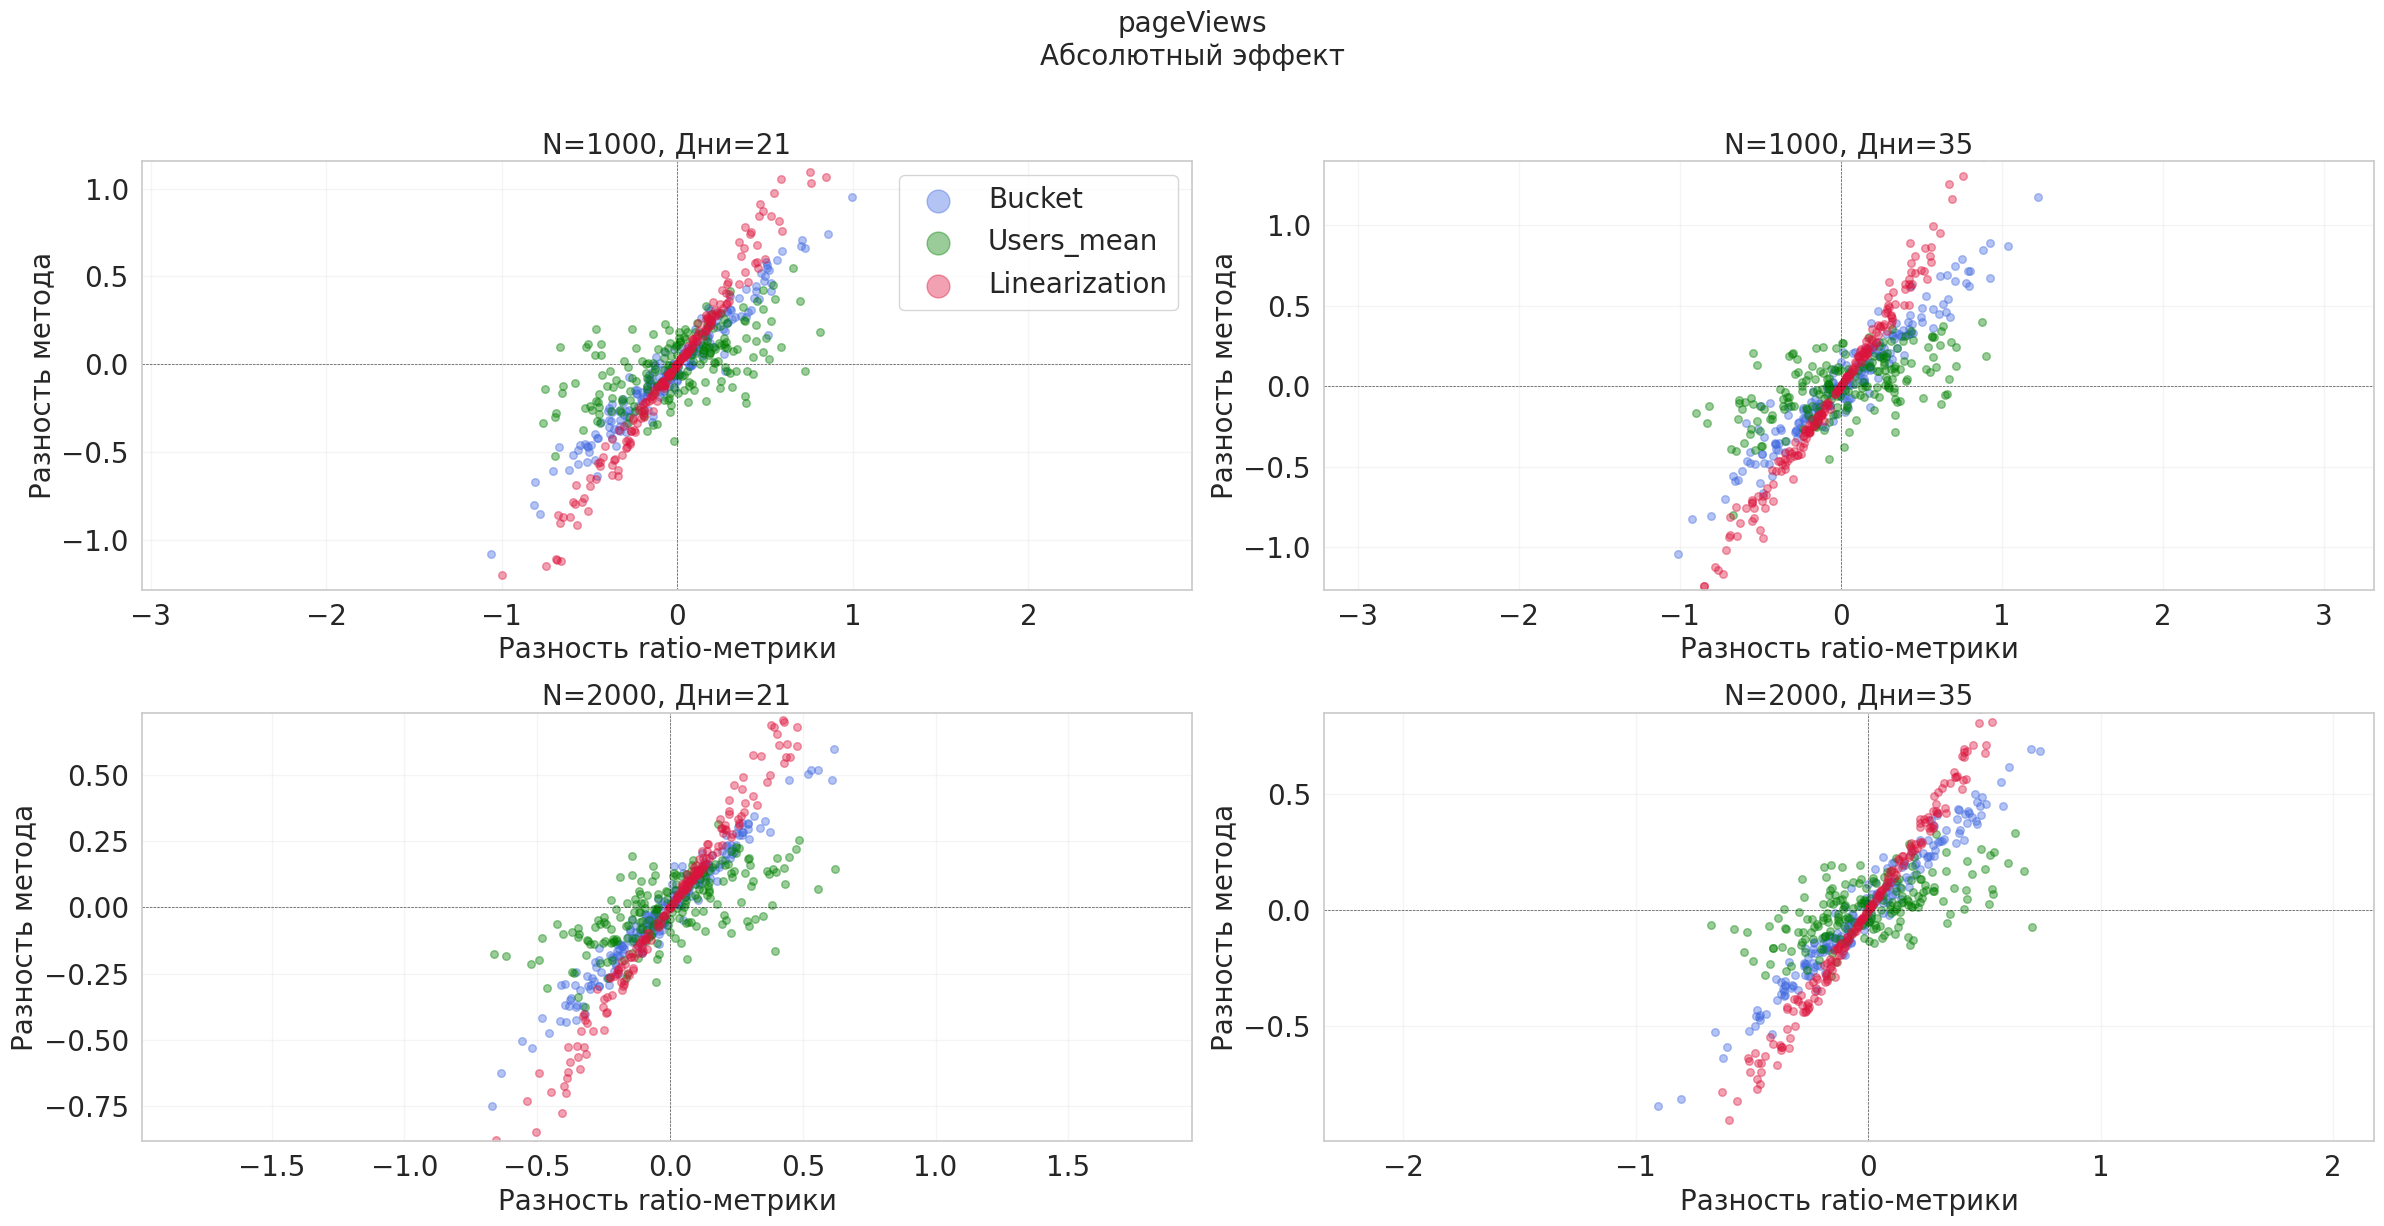

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

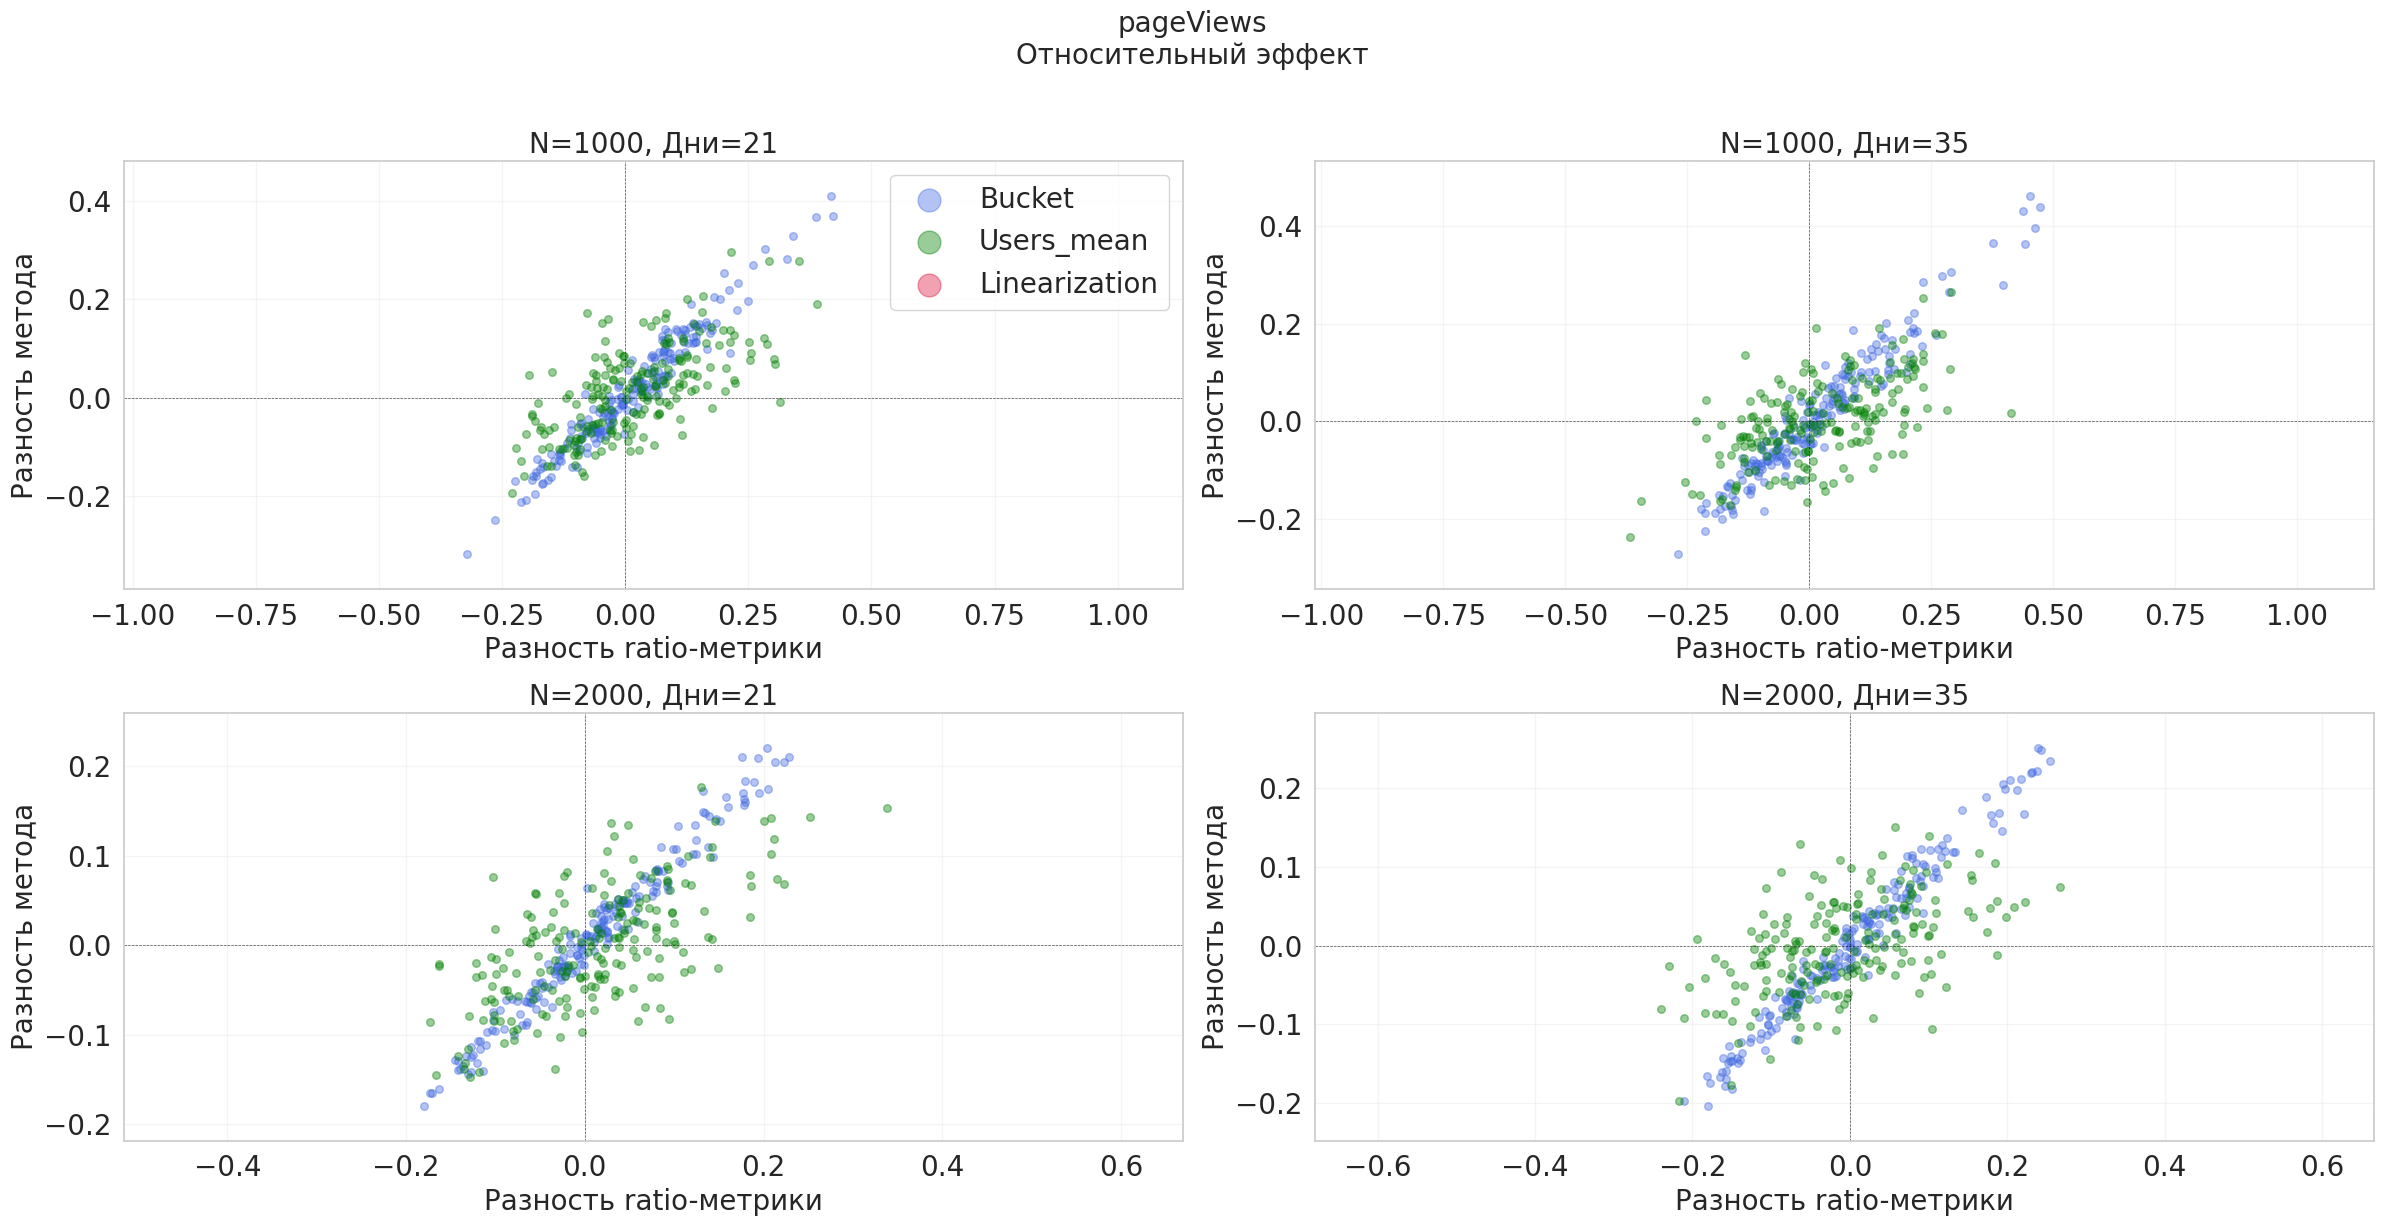

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

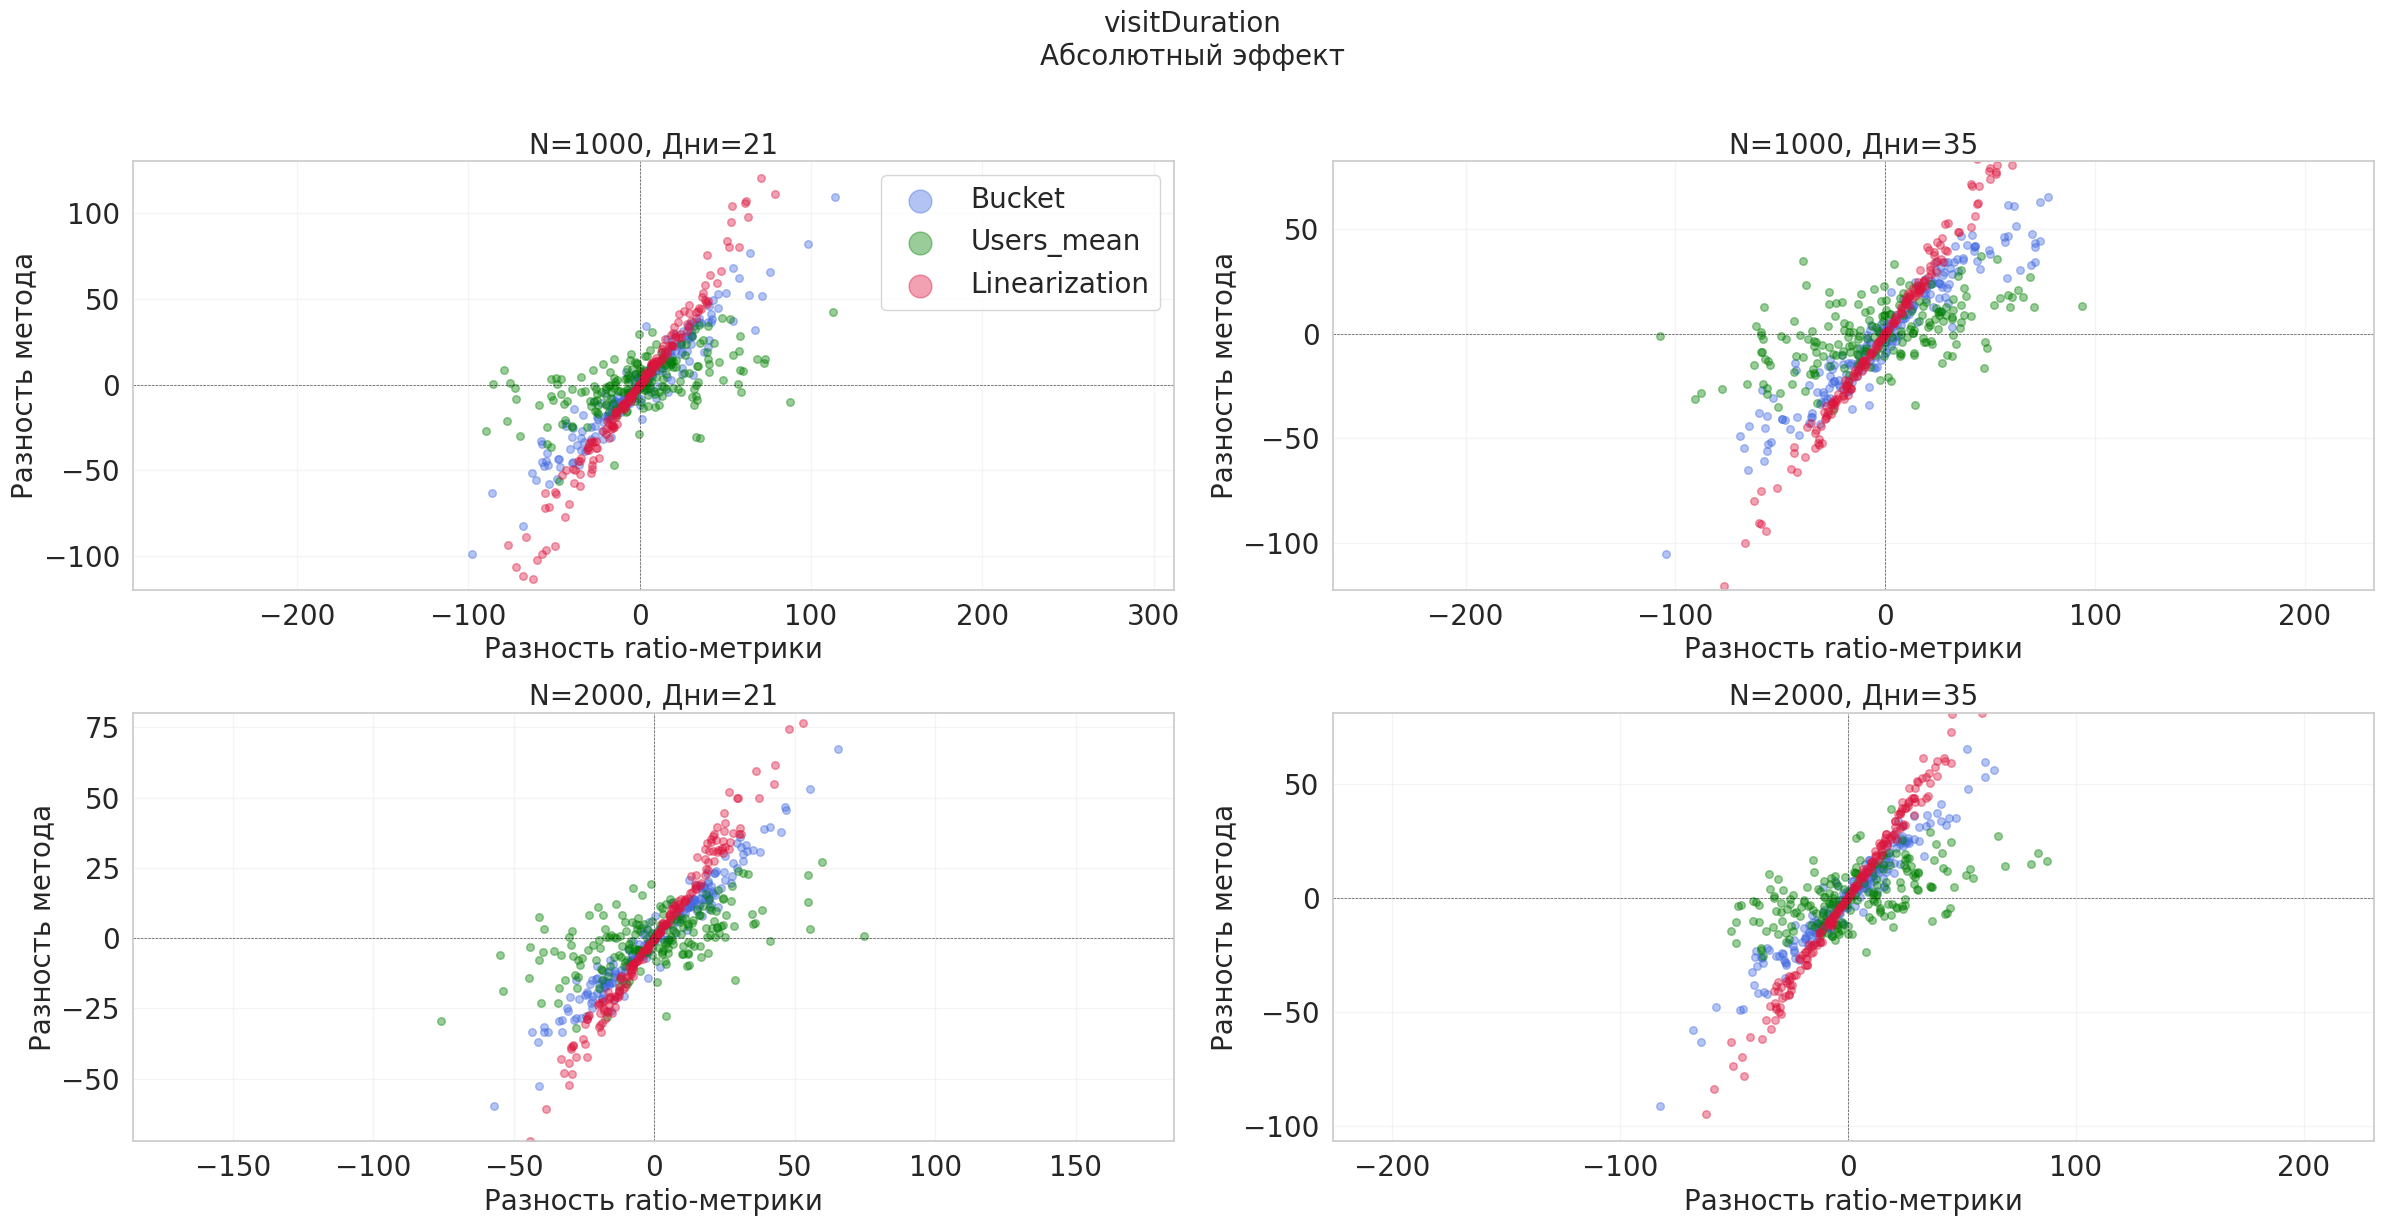

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

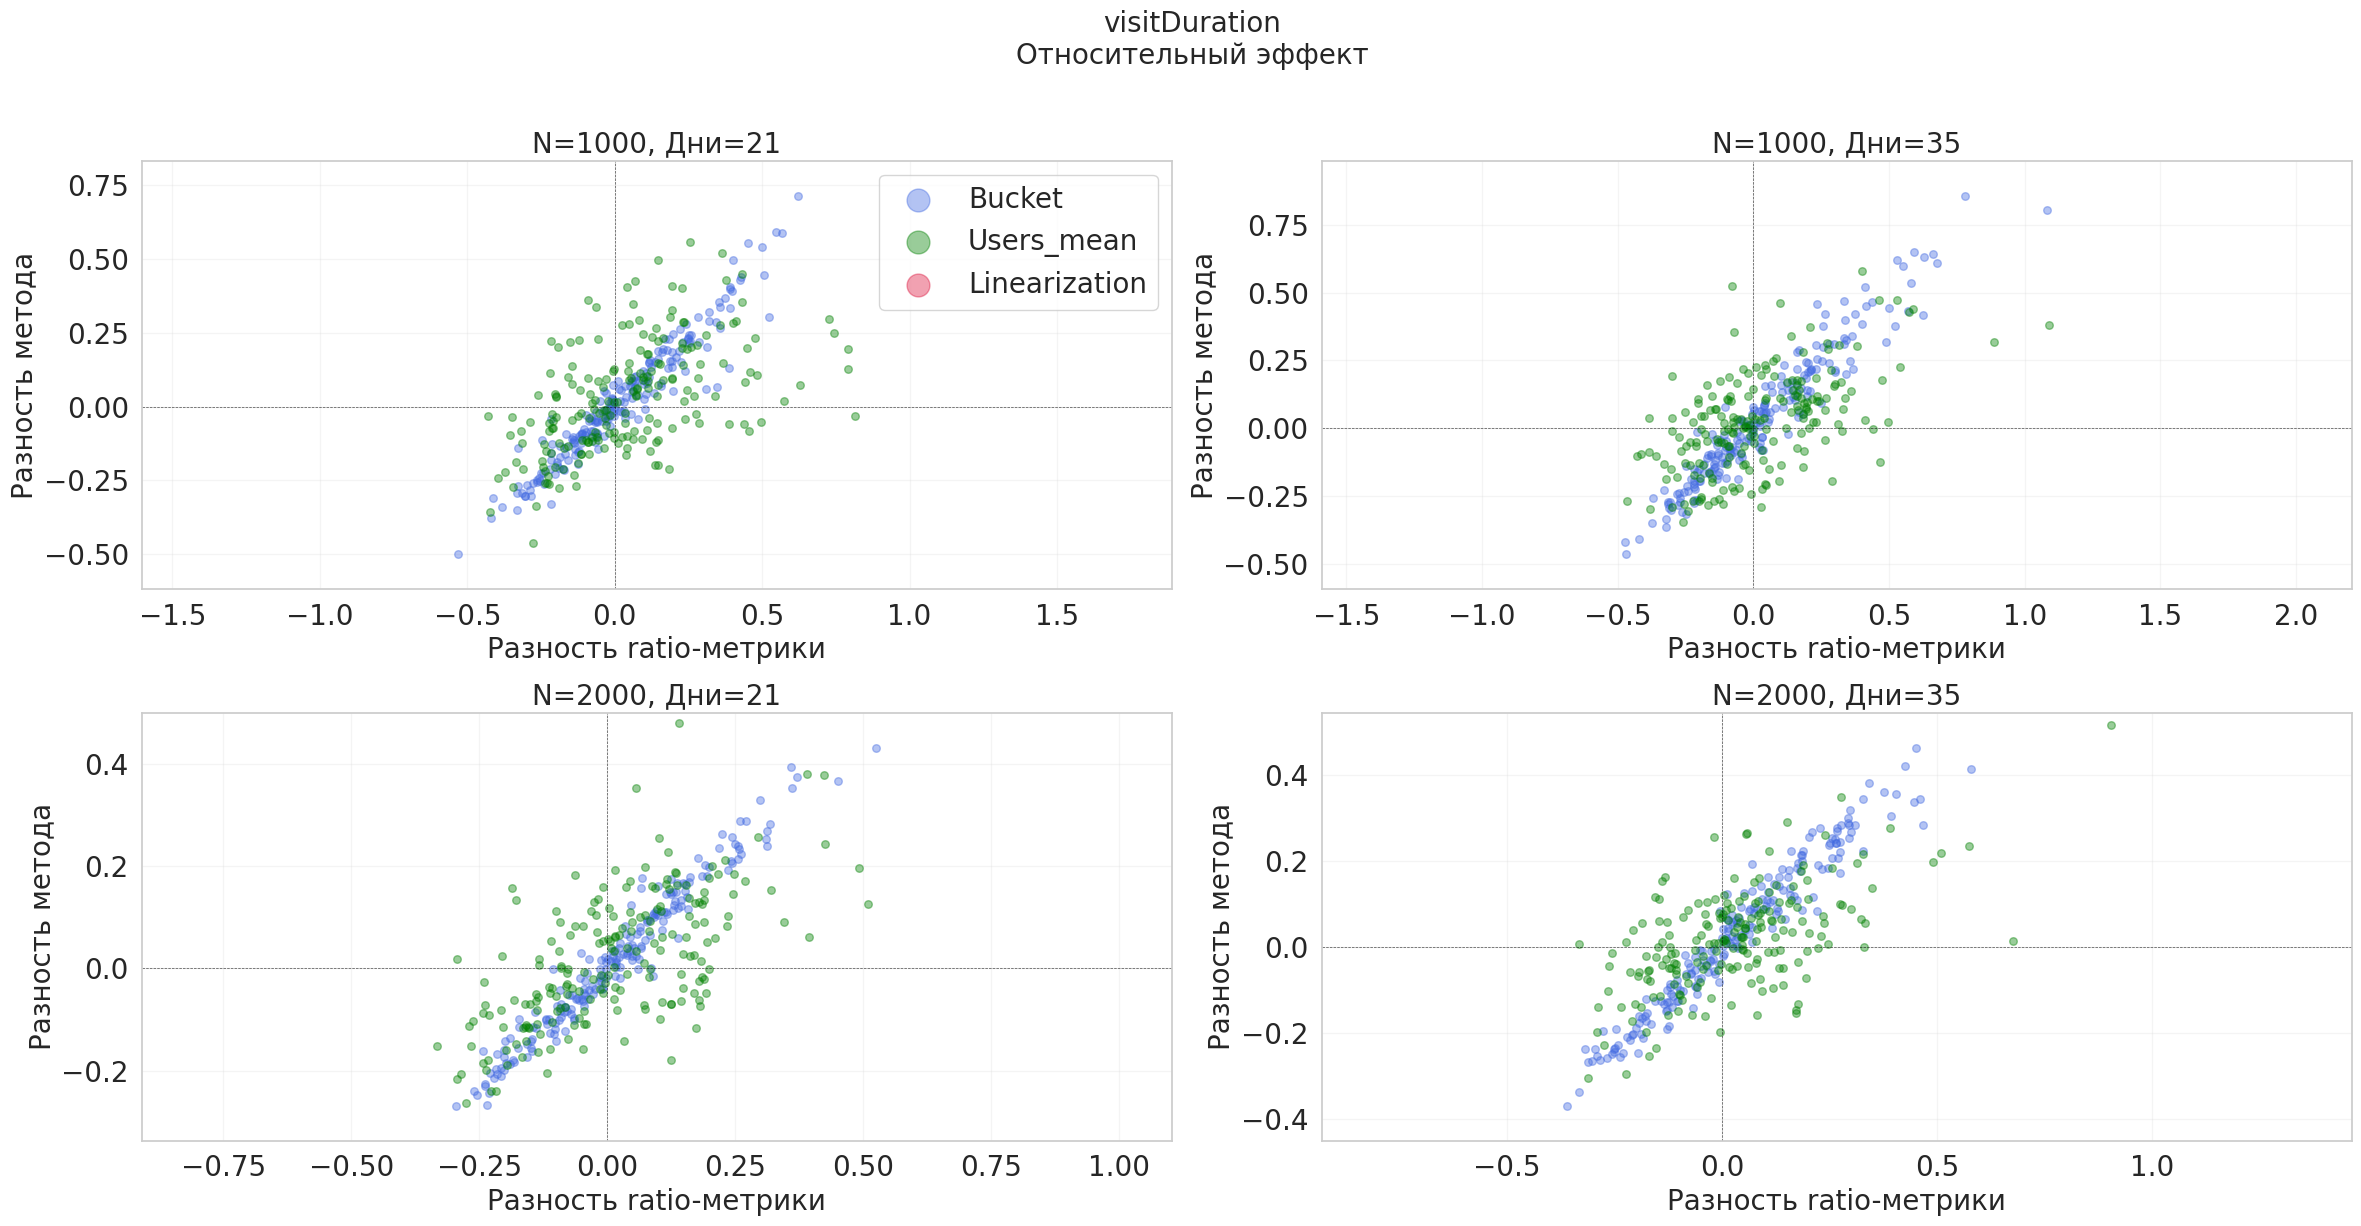

In [202]:
targets = ['pageViews', 'visitDuration']
sample_sizes = [1000, 2000]
test_dlits = [3*7, 5*7]

with np.errstate(divide='ignore', invalid='ignore'):
    plot_comparison_grid(targets, sample_sizes, test_dlits, limited=True)

Без ограничений по осям

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

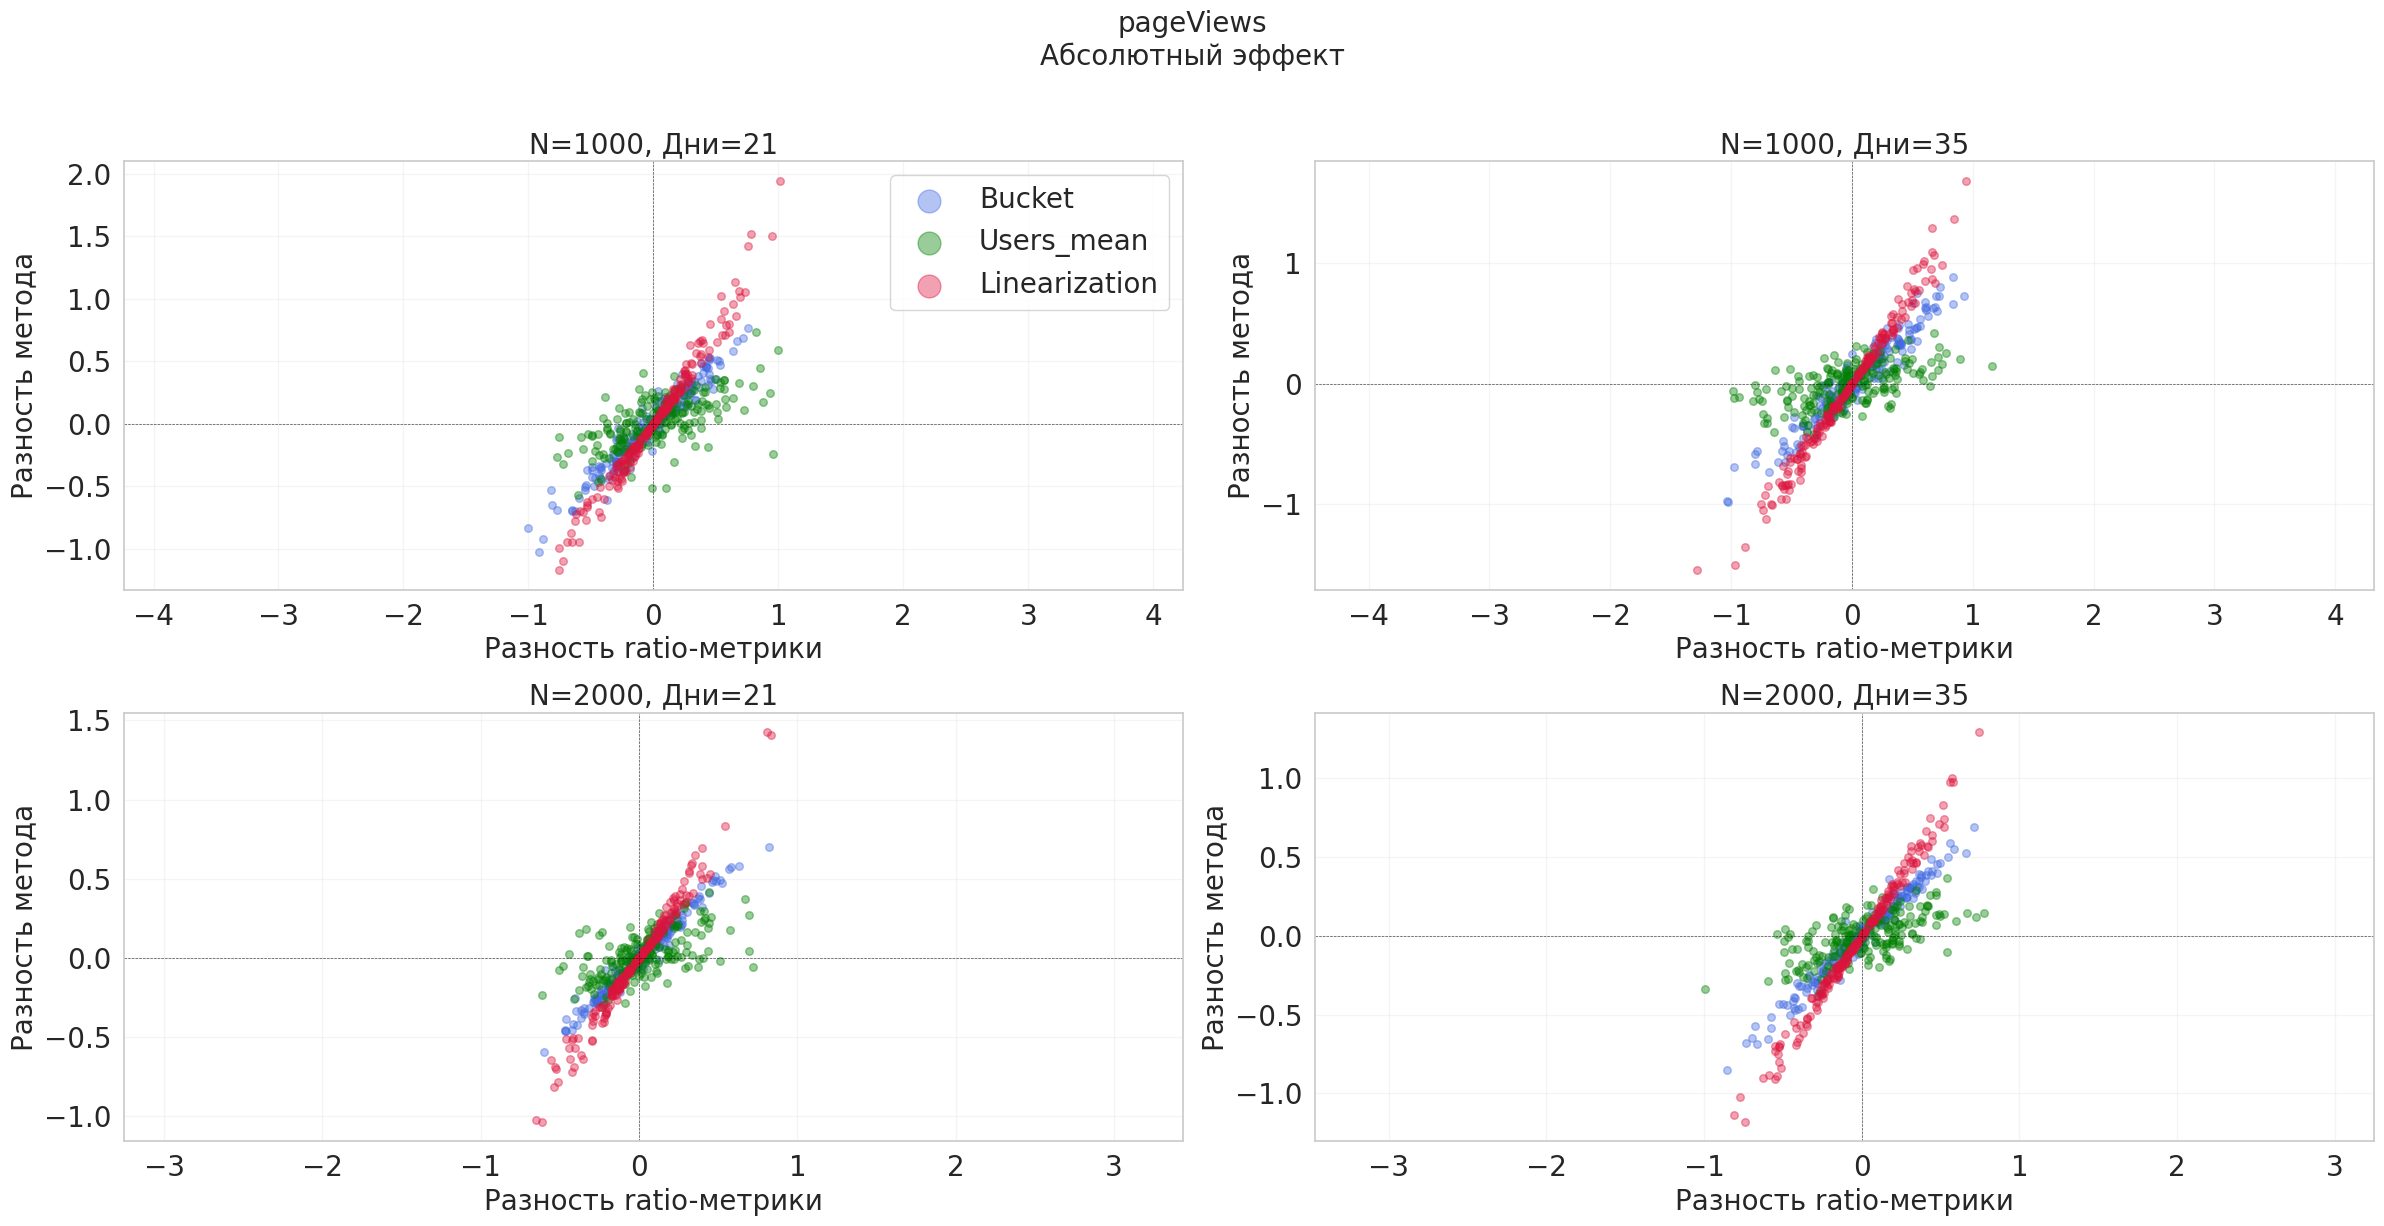

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

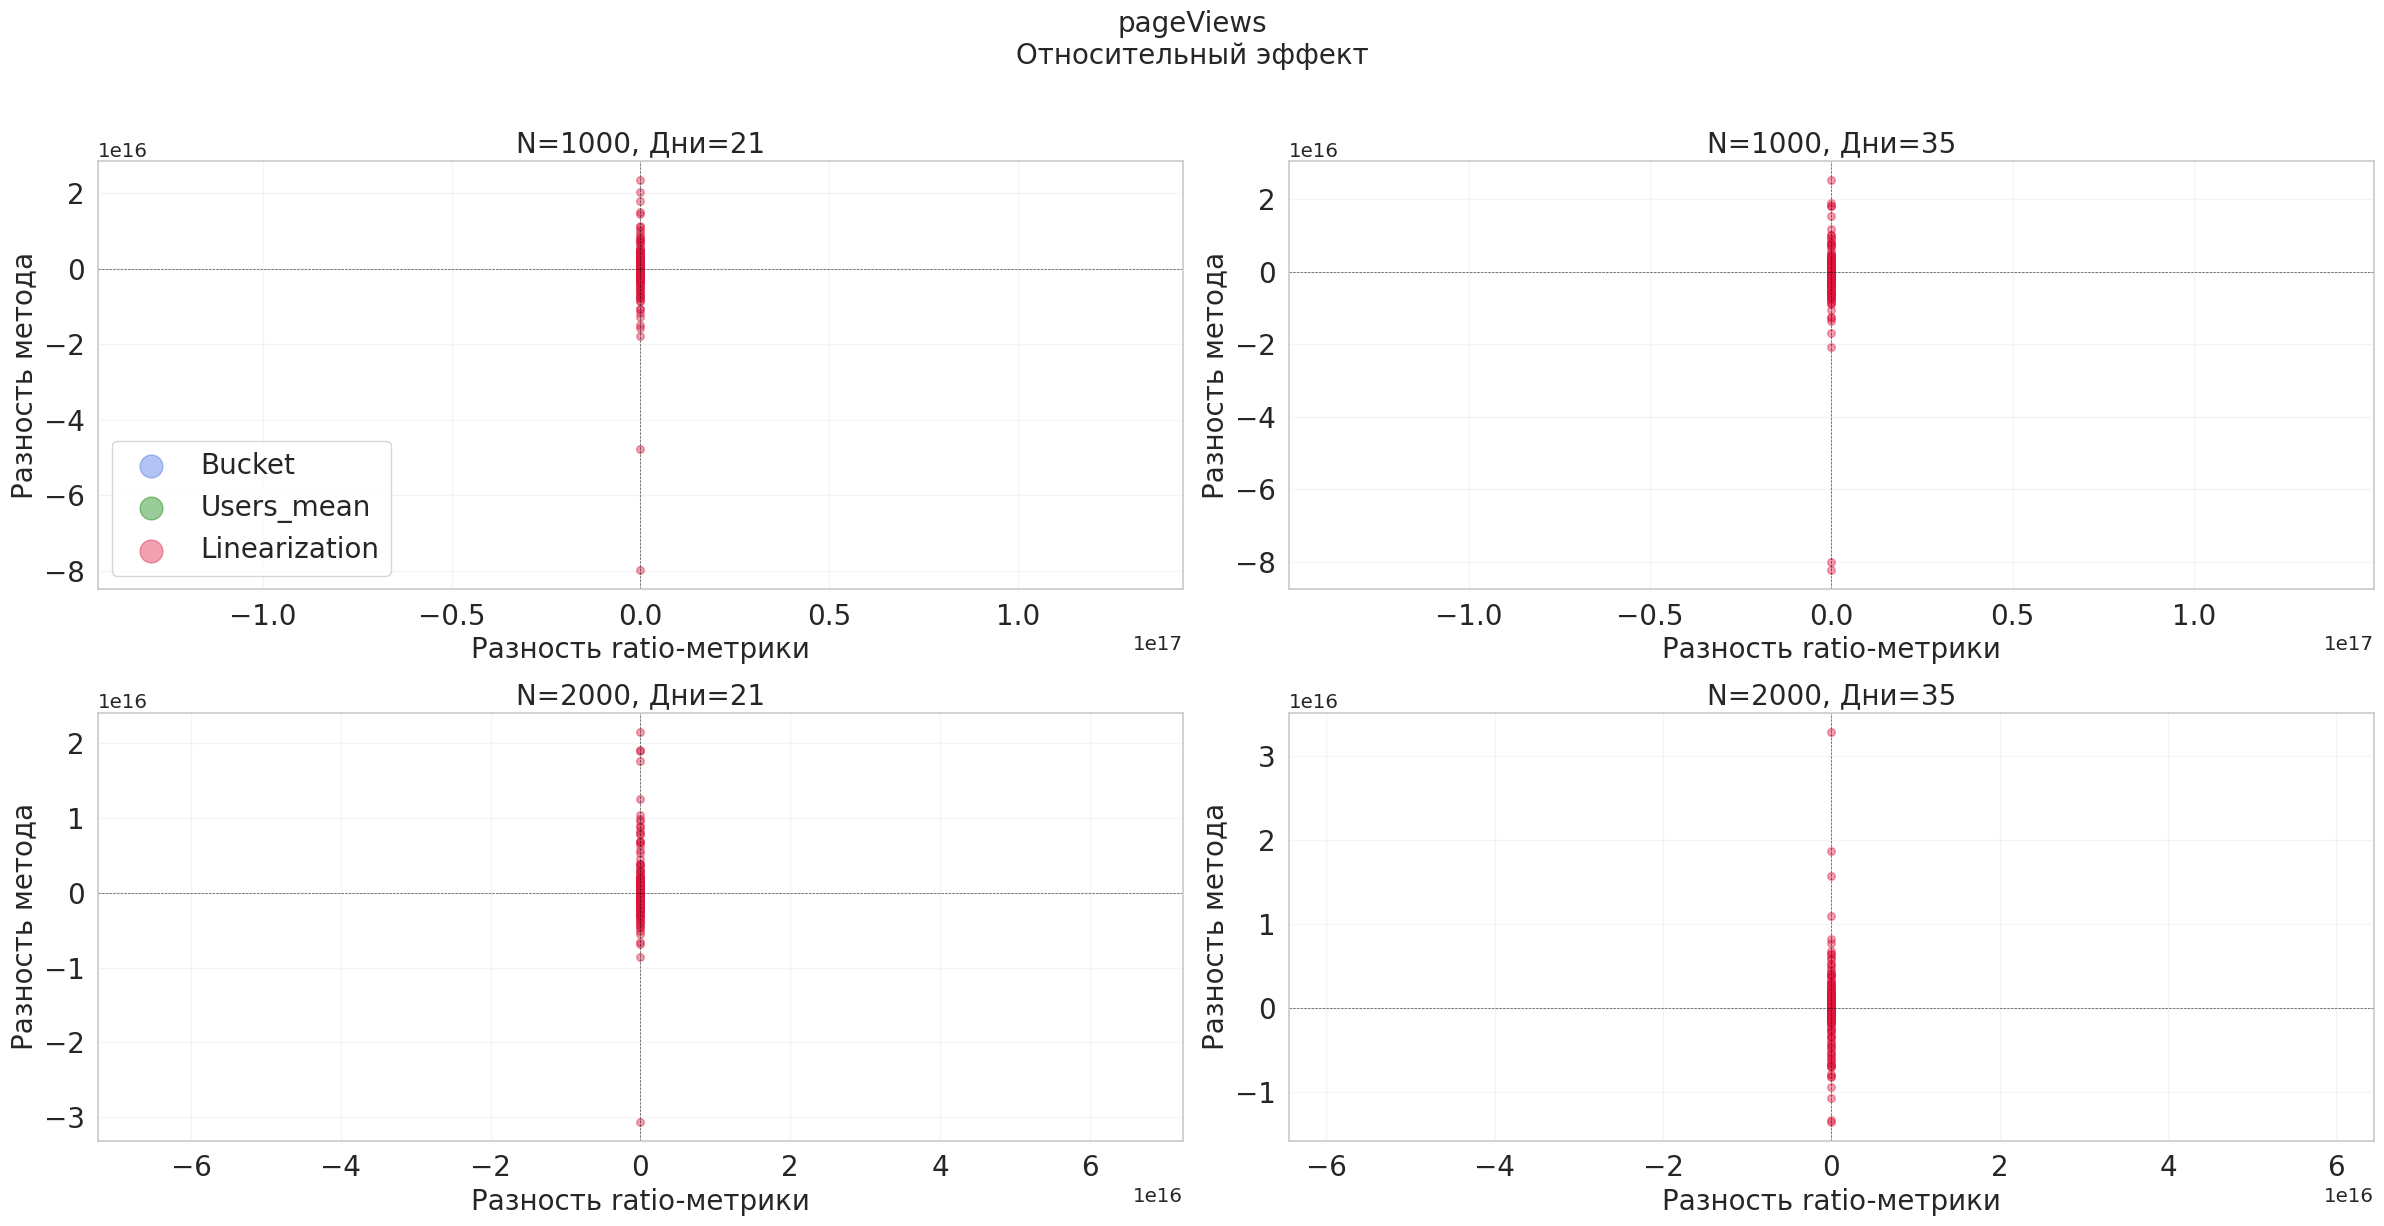

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

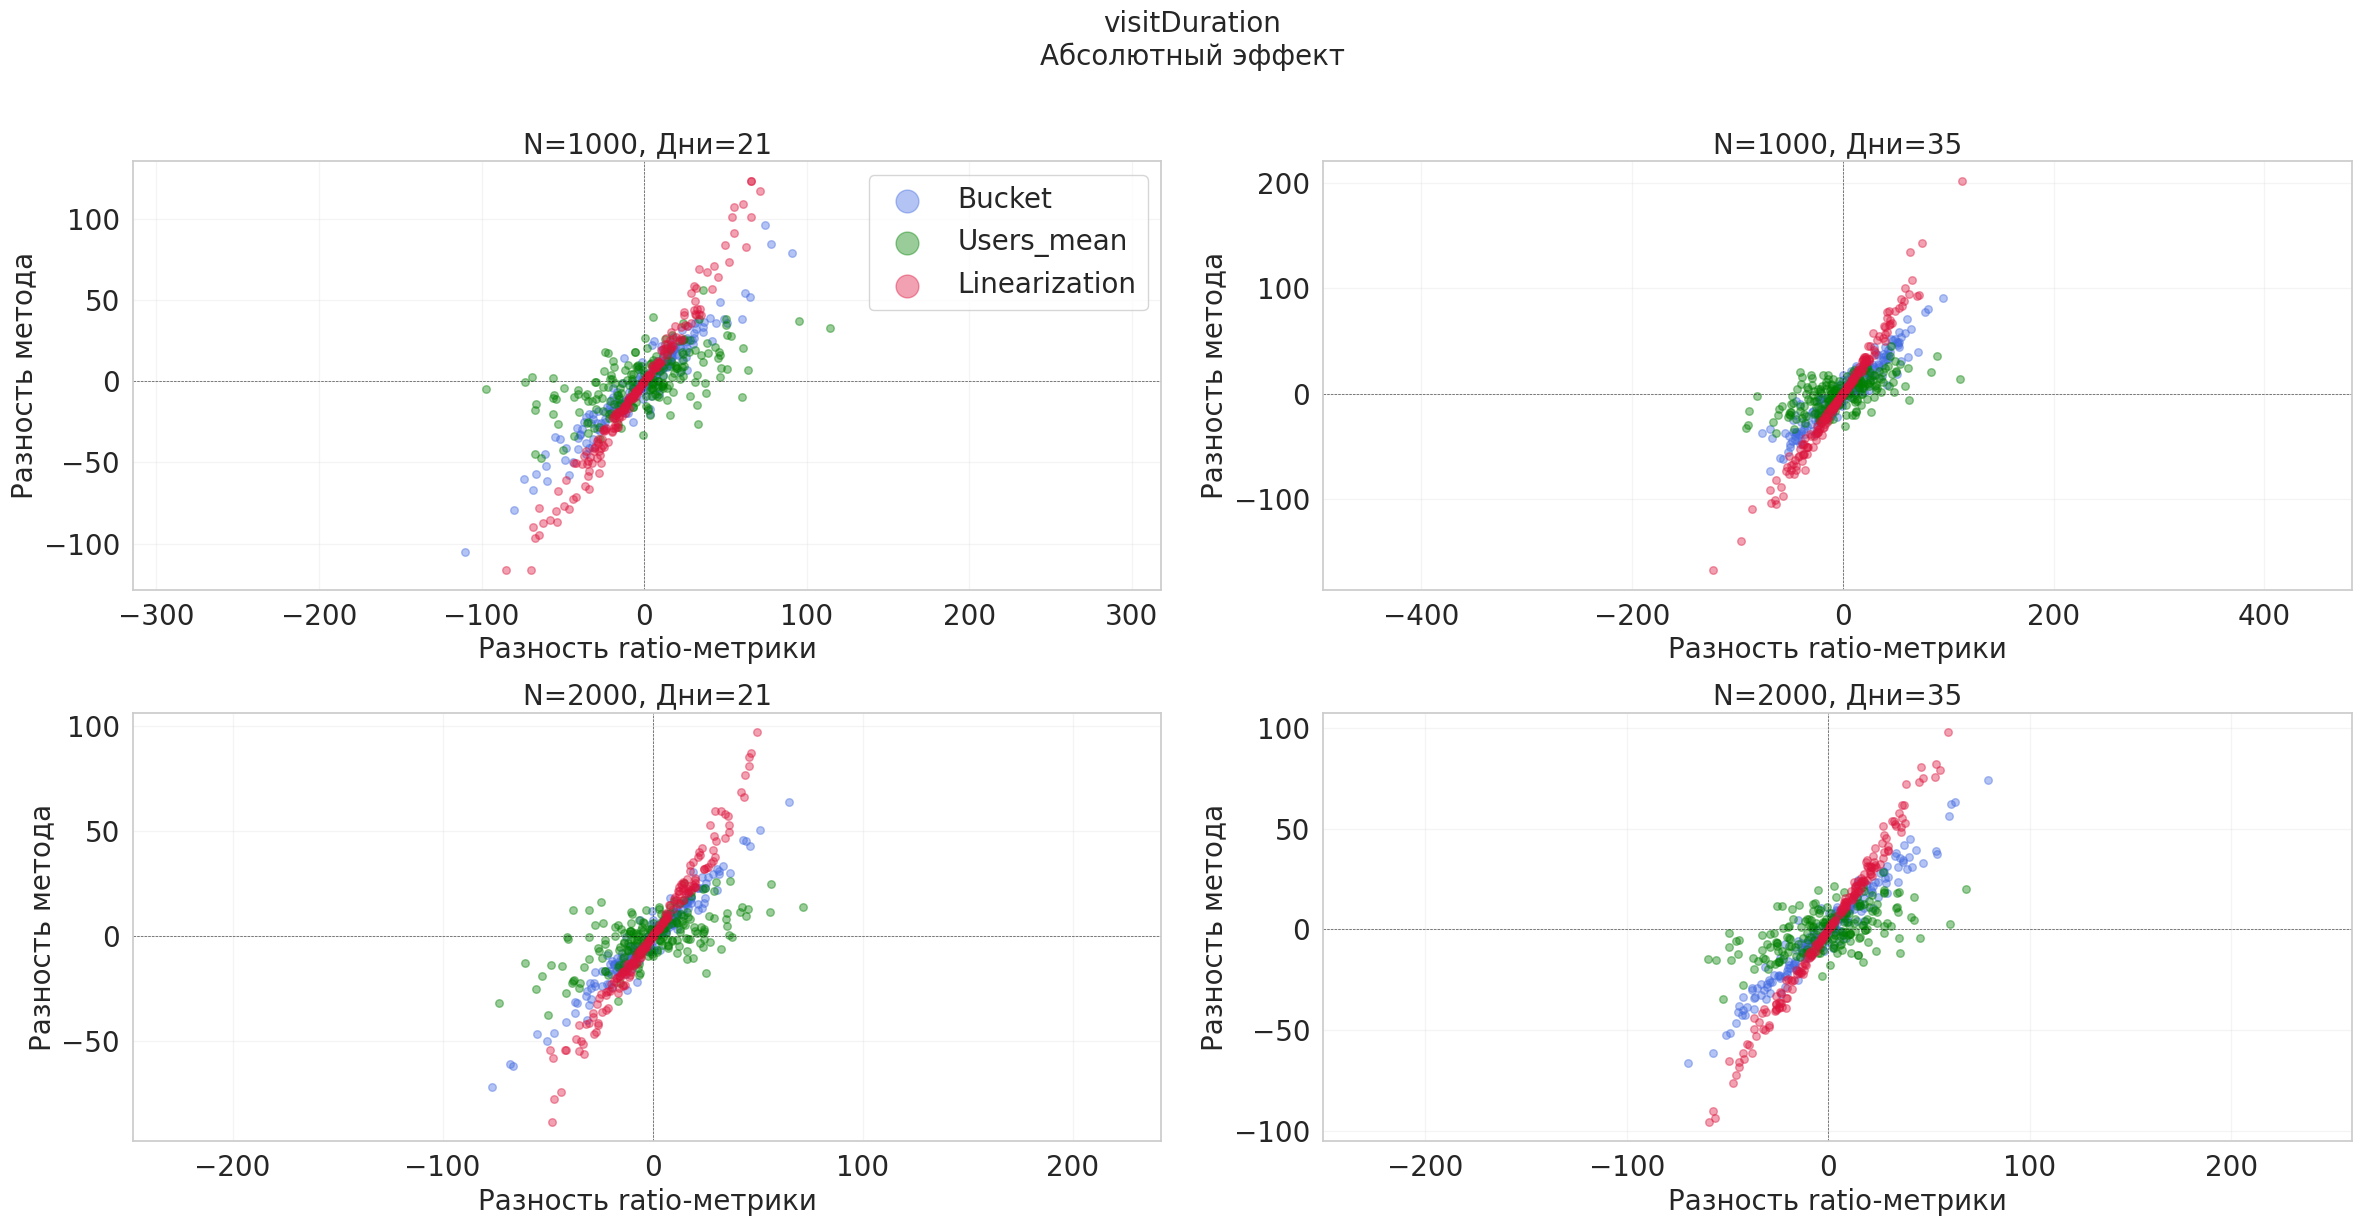

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

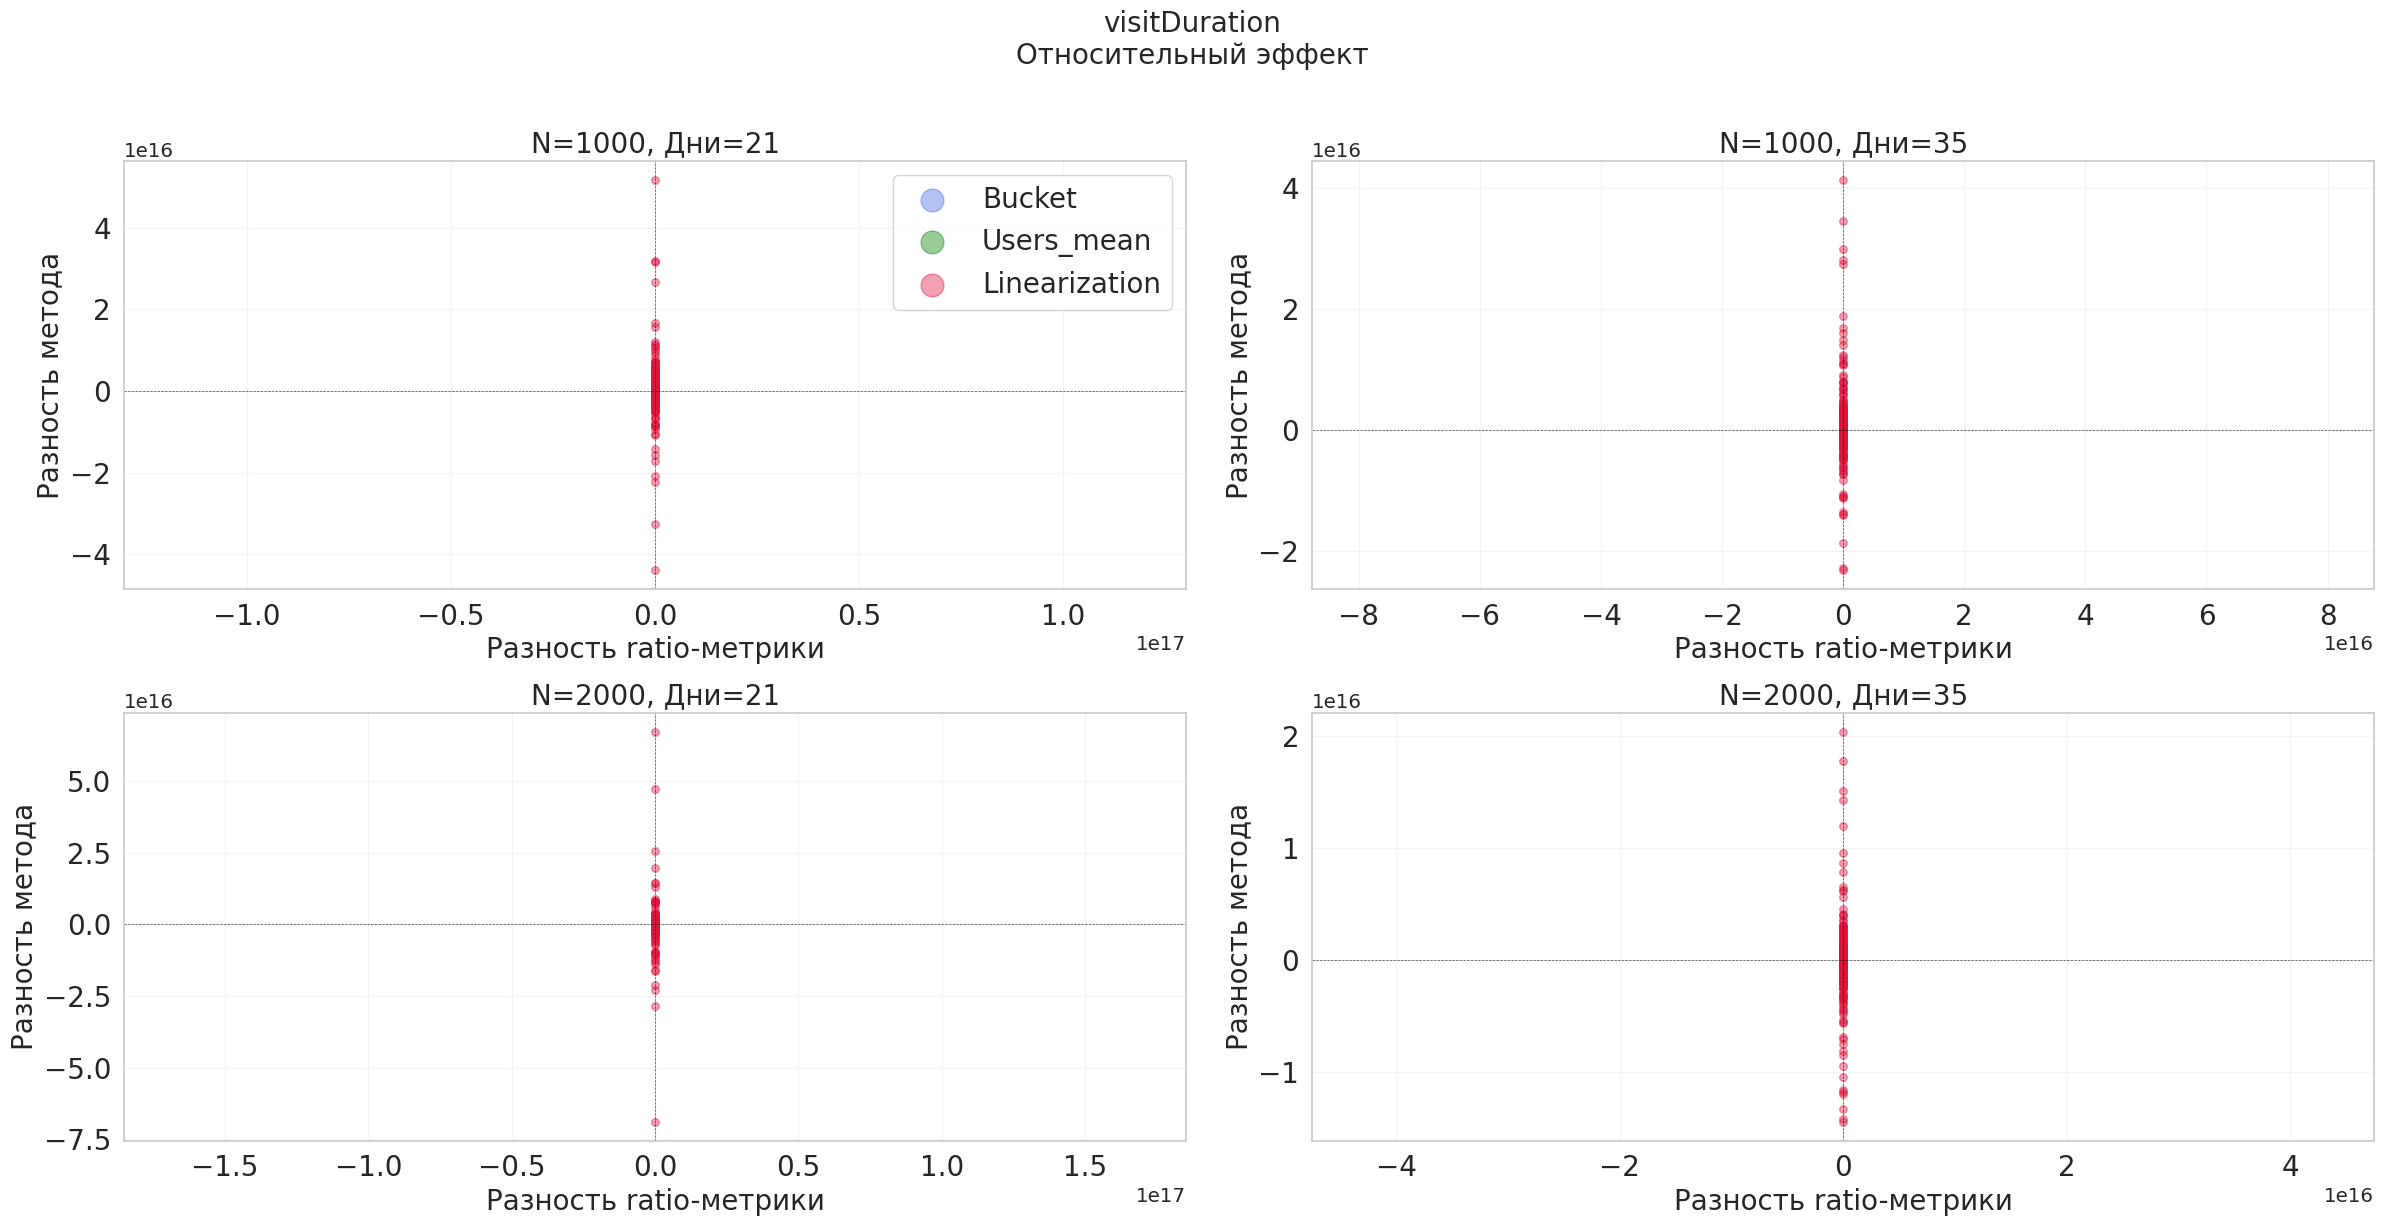

In [203]:
targets = ['pageViews', 'visitDuration']
sample_sizes = [1000, 2000]
test_dlits = [3*7, 5*7]

with np.errstate(divide='ignore', invalid='ignore'):
    plot_comparison_grid(targets, sample_sizes, test_dlits, limited=False)

Откуда, как и ожидалось, аггрегация по пользователям не сонаправлена, агрегация по бакетам +- сонаправлена, а линеаризация корректна только в абсолютной метрике - и там она очень хорошо сонаправлена

То есть получили ровно то, что и хотели

**2.** Провалидируй эксперимент из предыдущих домашек для линеаризации с CUPED и стратификацией.

По сути, сделать надо примерно то же самое, но добавить линеаризацию. Бери код линеаризации с занятия, а также реализацию теста с линеаризацией и CUPED. А также, может быть, код из предыдущих домашек. В общем, из нескольких реализаций надо сделать одну общую.

Подготовка

In [278]:
os = ["windows", "gnu_linux", "android", "macos", "ios_double"]
data = data[data["operatingSystemRoot"].isin(os)]

real_features = [
    "prepilot",
    "windowClientWidth",
    "windowClientHeight",
]

cat_features = [
    "has_prepilot",
    "operatingSystemRoot",
    "browser",
    "regionCountry",
    "screenOrientation",
    "networkType",
]

site_types = []
data["startURL"] = data["startURL"].astype(str)

for i in range(len(data)):
    if "github.io" in data["startURL"].iloc[i]:
        site_types.append(0)
    elif "gitlab.io" in data["startURL"].iloc[i]:
        site_types.append(1)
    elif "wiki.yandex.ru" in data["startURL"].iloc[i]:
        site_types.append(2)
    elif "forms.yandex.ru" in data["startURL"].iloc[i]:
        site_types.append(3)
    else:
        site_types.append(4)

data["siteType"] = site_types

Функции для визуализации

In [287]:
def estimate_reject_prob(n_rejects, n_iter):
    """
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    """

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(n_rejects, n_iter, method="wilson")

    return prob_reject, left_bound, right_bound


def visualization(
    prob_reject,
    left_bound,
    right_bound,
    show_pvals=False,
    pvals=None,
    alpha=0.05,
    figsize=(7, 2),
    title=None,
):
    """
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)
    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теор вероятность ошибки первого рода
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    """

    # построение гистограммы p-value (опционально)
    if show_pvals:
        with sns.axes_style("whitegrid"):
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            plt.hist(
                pvals,
                bins=np.linspace(0, 1, 21),
                alpha=0.7,
                weights=np.ones(len(pvals)) / len(pvals),
            )
            plt.title("Распределение p-value")

    # отрисовка интервала для вероятности отвержения критерия
    with sns.axes_style("whitegrid"):
        if show_pvals:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=figsize)
        plt.hlines(0, 0, 1, color="black", lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color="red", lw=5, linestyle="--", alpha=0.6)
        plt.fill_between(
            [left_bound, right_bound], [0.15] * 2, [-0.15] * 2, color="green", alpha=0.6
        )
        plt.scatter(prob_reject, 0, s=300, marker="*", color="red")
        plt.xlim((min(alpha, left_bound) - 1e-3, max(alpha, right_bound) + 1e-3))
        plt.title(
            f"Доля отвержений = {100*prob_reject:.2f}%, "
            f"интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)"
        )
        plt.suptitle(title)
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()


def draw_power(
    powers,
    left_powers,
    right_powers,
    effects_list=np.linspace(0, 0.1, 11),
    label=None,
    title="Графики мощности",
    new_figure=False,
):
    """
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    effects -- сетка эффектов
    real_alpha -- оценка реальной мощности
    left_alpha, right_alpha -- границы соотв. дов. интервала
    title -- заголовок графика
    """

    if new_figure:
        plt.figure(figsize=(10, 4))

    plt.plot(effects_list, powers, label=label, lw=3)
    plt.fill_between(effects_list, left_powers, right_powers, alpha=0.3)

    if new_figure:
        plt.hlines(
            0.8,
            effects_list[0],
            effects_list[-1],
            color="black",
            alpha=0.5,
            label="Мощность 0.8 (пересечение — MDE)",
        )
    plt.legend()
    plt.xlabel("Размер эффекта")
    plt.ylabel("Мощность")
    plt.title(title)

def run_1_iteration(
    test,
    generate_samples,
    target_name,
    add_effect,
    effects_list=[0],
    relative_effect=True,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    add_effect -- функция добавления эффекта
    effects_list --  массив размеров добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным

    Возвращает: pvalue
    """

    pvals = []
    for effect in effects_list:
        # Генерируем выборки
        x_data, y_data = generate_samples(data=data, effect=effect)
        # Применяем критерий
        pvals.append(test(x_data, y_data)[1])
    return pvals


def run_experiments(
    test,
    generate_samples,
    data=None,
    add_effect=add_effect,
    n_iter=10000,
    sample_size=1000,
    effect=0,
    relative_effect=True,
    n_jobs=4,
    alpha=0.05,
    target_name="pilot",
    draw=False,
    title=None,
    show_pvals=True,
):
    """
    Проведение серии AA-тестов на исторических данных.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    data -- исторические данные
    n_iter -- количество итераций
    sample_size -- размер выборок
    add_effect -- функция добавления эффекта
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теор вероятность ошибки первого рода
    target_name -- имя колонки с таргет-метрикой
    """

    # Проведение серии экспериментов
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(run_1_iteration)(
            test, generate_samples, target_name, add_effect, [effect], relative_effect
        )
        for _ in tqdm(range(n_iter), leave=False)
    )
    pvals = np.array(pvals).flatten()
    # Подсчет числа отвержений
    n_rejects = (pvals < alpha).sum()

    # Оценка вероятности отвержения
    prob_reject, left_bound, right_bound = estimate_reject_prob(n_rejects, n_iter)

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            prob_reject,
            left_bound,
            right_bound,
            show_pvals,
            pvals,
            alpha,
            figsize,
            title,
        )

    return prob_reject, (left_bound, right_bound)


def estimate_power(
    test,
    generate_samples,
    data=None,
    n_jobs=4,
    n_iter=10000,
    sample_size=1000,
    effects_list=np.linspace(0, 0.1, 11),
    relative_effect=True,
    alpha=0.05,
    target_name="pilot",
):
    """
    Проведение серии AA-тестов на исторических данных с добавением разных эффектов.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    data -- исторические данные
    n_iter -- количество итераций
    sample_size -- размер выборок
    add_effect -- функция добавления эффекта
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теор вероятность ошибки первого рода
    target_name -- имя колонки с таргет-метрикой
    """
    # Проведение серии экспериментов
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(run_1_iteration)(
            test,
            generate_samples,
            target_name,
            add_effect,
            effects_list,
            relative_effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )

    # Подсчет числа отвержений
    n_rejects = (np.array(pvals) < alpha).sum(axis=0)

    # Оценка мощности
    powers, left_bounds, right_bounds = estimate_reject_prob(n_rejects, n_iter)

    return powers, left_bounds, right_bounds

Функции генерации и тестов

In [288]:
def linearization(
    control_data,
    test_data,
    numerator_name="pageViews",
    denominator_name=None,
    user_name="clientID",
    eta=0,
):
    """
    Реализация линеаризации ratio-метрики.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации

    Возвращает:
    control_users, test_users -- таблицу с поюзерными линеаризованными метриками,
    которые записаны в колонках linearization_values
    """
    cols_to_group = [user_name, numerator_name]
    if denominator_name:
        cols_to_group.append(denominator_name)
    
    control_data = control_data[cols_to_group]
    test_data = test_data[cols_to_group]
    
    if denominator_name is None:
        control_data = control_data.copy()
        test_data = test_data.copy()

        denominator_name = "ratio_denominator"
        control_data[denominator_name] = 1
        test_data[denominator_name] = 1

    # Коэффициент линеаризации
    kappa = (1 - eta) * ratio_metric(
        control_data, numerator_name, denominator_name
    ) + eta * ratio_metric(test_data, numerator_name, denominator_name)

    # Группируем по пользователям
    control_users = control_data.groupby(user_name, as_index=False).sum()
    test_users = test_data.groupby(user_name, as_index=False).sum()

    # Вычисляем линеаризованные метрики
    control_users["linearization_values"] = (
        control_users[numerator_name] - kappa * control_users[denominator_name]
    )
    test_users["linearization_values"] = (
        test_users[numerator_name] - kappa * test_users[denominator_name]
    )

    return control_users, test_users
    
def generate_subarray_covariates(
    data,
    agg_dict,
    date_valid_start=date_valid_start,
    date_valid_end=date_valid_end,
    test_dlit=test_dlit,
    test_control_size=test_control_size,
    fraq_test=fraq_test,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
    real_features=real_features,
    cat_features=cat_features,
    cuped=False,
    effect=0,
    relative_effect=False
):
    """
    Генерация выборок 2-x групп посредством случайного деления пользователей на 2 равные группы
    Агрегация данных по пользователям

    Аргументы:
    data -- данные
    date_valid_start, date_valid_end -- временные границы валидации
    test_dlit -- длительность истории, которую берем в тест
    test_control_size -- размер теста+контроля
    fraq_test -- доля тестовой группы

    Возвращает:
    test_groupped, control_groupped -- сгруппированные данные по тесту и контролю
    """

    # определяем временные границы теста
    all_days = (date_valid_end - date_valid_start).days - test_dlit
    diff_from_start = np.random.choice(all_days, 1)[0]
    start_date = date_valid_start + pd.to_timedelta(diff_from_start, "D")
    end_date = start_date + pd.to_timedelta(test_dlit, "D")

    # берем нужный срез данных по времени
    data_start_end = data[
        (data[date_column] >= start_date) & (data[date_column] < end_date)
    ]

    # из всех пользователей выбираем тест и контроль
    users = data_start_end[user_column].unique()
    test_size = int(test_control_size * fraq_test)
    control_size = test_control_size - test_size
    test_users = np.random.choice(users, test_size, replace=False)
    other_users = list(set(users) - set(test_users))
    control_users = np.random.choice(
        other_users, min(control_size, len(other_users)), replace=False
    )

    # берем нужный срез данных по пользователям
    test = data_start_end[data_start_end[user_column].isin(test_users)]
    control = data_start_end[data_start_end[user_column].isin(control_users)]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        if relative_effect:
            test.loc[:, target_column] *= (1 + effect)  # Умножаем на (1 + effect)
        else:
            test.loc[:, target_column] += effect  # Добавляем effect


    control_linearization, test_lineatization = linearization(control, test,
                                                     numerator_name=target_column)

    # Объединяем control и test по user_column
    test = test.merge(test_lineatization[[user_column, "linearization_values"]], on=user_column, how='left')
    control = control.merge(control_linearization[[user_column, "linearization_values"]], on=user_column, how='left')

    
    # агрегируем данные
    test_groupped = test.groupby(user_column).agg(agg_dict)
    control_groupped = control.groupby(user_column).agg(agg_dict)

    # возвращаем данные в нужном виде
    if cuped:
        test_groupped = count_prepilot_metric(
            data,
            test_groupped,
            start_date,
            test_dlit=test_dlit,
            date_column=date_column,
            user_column=user_column,
            target_column=target_column,
        )
        control_groupped = count_prepilot_metric(
            data,
            control_groupped,
            start_date,
            test_dlit=test_dlit,
            date_column=date_column,
            user_column=user_column,
            target_column=target_column,
        )

        return test_groupped, control_groupped
    return test_groupped, control_groupped

def count_prepilot_metric(
    data,
    group,
    start_date,
    test_dlit=28,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
):
    """
    Считаем метрику на препилоте

    Аргументы:
    data -- данные
    group -- сгруппированные данные
    start_date -- дата старта теста
    test_dlit -- длительность истории, которую берем в тест

    Возвращает:
    group -- сгруппированные данные c метрикой на препилоте
    """

    # берем нужный срез по датам
    prepilot_start_date = start_date - pd.to_timedelta(test_dlit, "D")
    prepilot_end_date = start_date - pd.to_timedelta(1, "D")

    prepilot = data[
        (data[date_column] >= prepilot_start_date)
        & (data[date_column] < prepilot_end_date)
    ]
    
    # берем нужный срез по пользователям
    users = group.index.unique()
    prepilot_group = prepilot[prepilot[user_column].isin(users)]

    # группируем данные
    prepilot_groupped = prepilot_group.groupby(user_column)[[target_column]].mean()

    # заполняем данными препилота
    group["prepilot"] = prepilot_groupped[target_column]
    group["has_prepilot"] = group["prepilot"].apply(lambda x: 0 if pd.isnull(x) else 1)
    group["prepilot"] = group["prepilot"].fillna(0)
    return group

def regression_ttest(
    x_data,
    y_data,
    cuped=False,
    stratified=False,
    sample_name="linearization_values",
    treatment_name="treatment",
    covariate_names=[],
    strat_names=[],
):
    """
    T-test с CUPED/без CUPED, со стратификацией/без реализованный через линейную регрессию

    Аргументы:
    x, y -- выборки одинакового размера
    :param cuped: применять ли cuped
    :param stratified: применять ли стратификацию
    :param sample_name: имя столбца с целевым признаком
    :param covariate_names: массив имен столбцов-ковариат
    :param strat_names: массив имен стратификационных столбцов

    Возвращает:
    stat -- статистика критерия
    pvalue
    left_bound, right_bound -- границы дов. интервала
    """
    
    x_data_cp = x_data.copy() # тест
    y_data_cp = y_data.copy() # контроль
    
    # добавляем столбец с индикатором тестовой группы
    x_data[treatment_name] = 1
    y_data[treatment_name] = 0
    # объединяем тест и контроль в один датасет
    data = pd.concat([x_data, y_data])
    # удаляем ненужные столбцы из датасета
    if not cuped:
        covariate_names = []
    if not stratified:
        strat_names = []
    data = data[
        [treatment_name] + list(covariate_names) + list(strat_names) + [sample_name]
    ]

    # делаем стратификацию по нужным фичам
    data = pd.get_dummies(data, columns=strat_names)

    # определяем имена фичей, на которых будем обучать модель
    feature_names = list(set(data.columns) - set([sample_name]))

    # обучаем модель
    data = data.rename(columns=lambda x: x.replace(' ', '_').replace('-', '_'))
    feature_names = [col.replace(' ', '_').replace('-', '_') for col in feature_names]
    model = ols(f"{sample_name} ~ " + "+".join(feature_names), data=data).fit()
    # забираем таблицу с результатами
    summary = model.summary2().tables[1]
    # берем из таблицы нужные поля
    stat = summary.loc[treatment_name, "t"]
    pvalue = summary.loc[treatment_name, "P>|t|"]
    left_bound = summary.loc[treatment_name, "[0.025"]
    right_bound = summary.loc[treatment_name, "0.975]"]
    return stat, pvalue, left_bound, right_bound


Валидация

Линеаризация + стратификация


  0%|          | 0/500 [00:00<?, ?it/s]

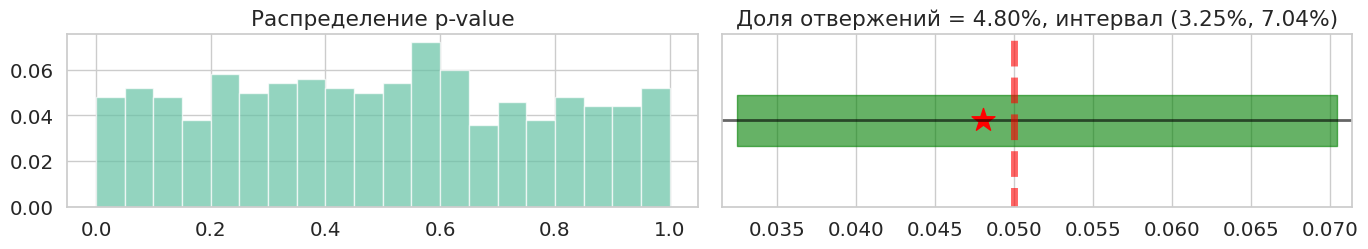

CUPED + линеаризация + стратификация


  0%|          | 0/500 [00:00<?, ?it/s]

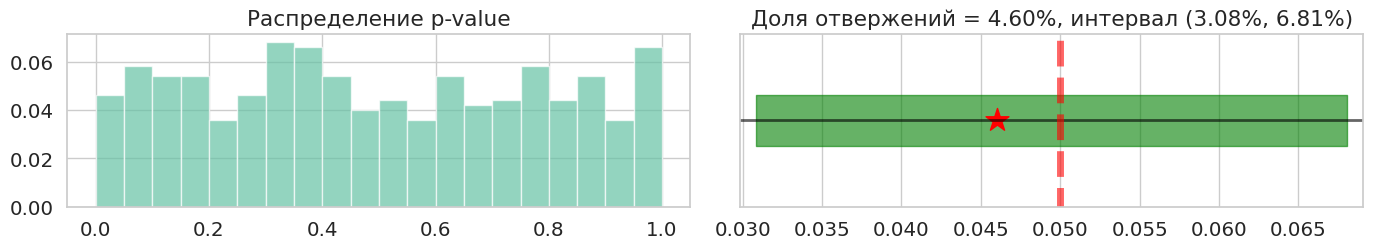

In [295]:
agg_dict = {
    "pageViews": "mean",
    "operatingSystemRoot": lambda x: x.iloc[0],
    "linearization_values": "mean"
}

tests = [
    lambda x, y: regression_ttest(
        x,
        y,
        cuped=False,
        stratified=True,
        strat_names=["operatingSystemRoot"],
        sample_name="linearization_values",
    ),
    lambda x, y: regression_ttest(
        x,
        y,
        cuped=True,
        stratified=True,
        covariate_names=["prepilot"],
        strat_names=[
            "has_prepilot",
            "operatingSystemRoot",
        ],
        sample_name="linearization_values",
    ),
]

generate_samples_list = [
    lambda data, effect: generate_subarray_covariates(data, agg_dict=agg_dict),
    lambda data, effect: generate_subarray_covariates(data, agg_dict=agg_dict, cuped=True),
]
names = [
    "Линеаризация + стратификация",
    "CUPED + линеаризация + стратификация",
]

for test, generate_samples, name in zip(tests, generate_samples_list, names):
    print(name)
    run_experiments(
        test=test,
        generate_samples=generate_samples,
        target_name="linearization_values",
        data=data,
        n_iter=500,
        alpha=0.05,
        show_pvals=True,
        draw=True,
        n_jobs=-1,
    );

Сравни критерии по линеаризованной метрике по мощности при использовании CUPED и в простом случае.

Линеаризация + стратификация


  0%|          | 0/500 [00:00<?, ?it/s]

CUPED + линеаризация + стратификация


  0%|          | 0/500 [00:00<?, ?it/s]

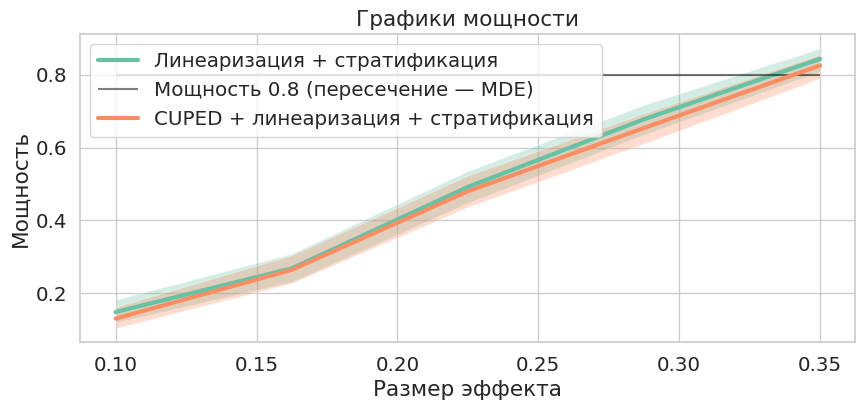

In [296]:
import warnings

generate_samples_list = [
    lambda data, effect: generate_subarray_covariates(data, agg_dict=agg_dict,
                                                      effect=effect),
    lambda data, effect: generate_subarray_covariates(data, agg_dict=agg_dict,
                                                      cuped=True, effect=effect),
]

powers_list = []
left_bounds_list = []
right_bounds_list = []
effects_list = np.linspace(0.1, 0.35, 5)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    for i, (test, generate_samples, name) in enumerate(
        zip(tests, generate_samples_list, names)
    ):
        print(name)
        powers, left_bounds, right_bounds = estimate_power(
            test=test,
            generate_samples=generate_samples,
            target_name="linearization_values",
            effects_list=effects_list,
            data=data,
            n_iter=500,
            alpha=0.05,
            n_jobs=-1,
        )
        powers_list.append(powers)
        left_bounds_list.append(left_bounds)
        right_bounds_list.append(right_bounds)
        draw_power(
            powers,
            left_bounds,
            right_bounds,
            effects_list=effects_list,
            label=name,
            new_figure=(i == 0),
        )

**Вывод:** 

Линеаризация работает, CUPED тоже - но сильно мощности не повысили. Что ожидаемо, у нас в этой задаче ничего существенно мощность не повышает.

Оба метода корректны

Вот и все, задание закончилось, вроде же хорошо мы вместе решили задачки, правда?)

Пришлось дебажить код, причем очень много. Ну такое

А вот графиками во втором пункте я доволен